In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import collections
import struct

import sys
sys.path.append('../Tianwen')

import ccsds

plt.rcParams['figure.figsize'] = (7, 3.5)
plt.rcParams['figure.facecolor'] = 'w'

from construct import *

from gnuradio.digital import crc

In [2]:
TMPrimaryHeader = BitStruct(
    'transfer_frame_version_number' / BitsInteger(2),
    'spacecraft_id' / BitsInteger(10),
    'virtual_channel_id' / BitsInteger(3),
    'ocf_flag' / Flag,
    'master_channel_frame_count' / BitsInteger(8),
    'virtual_channel_frame_count' / BitsInteger(8),
    'secondary_header_flag' / Flag,
    'synch_flag' / Flag,
    'packet_order_flag' / Flag,
    'segment_length_id' / BitsInteger(2),
    'first_header_pointer' / BitsInteger(11)
)

CLCW = BitStruct(
    'control_word_type' / Flag,
    'clcw_version_number' / BitsInteger(2),
    'status_field' / BitsInteger(3),
    'cop_in_effect' / BitsInteger(2),
    'virtual_channel_identification' / BitsInteger(6),
    'rsvd_spare' / BitsInteger(2),
    'no_rf_avail' / Flag,
    'no_bit_lock' / Flag,
    'lock_out' / Flag,
    'wait' / Flag,
    'retransmit' / Flag,
    'farm_b_counter' / BitsInteger(2),
    'rsvd_spare2' / BitsInteger(1),
    'report_value' / BitsInteger(8)
)

TMFrame = Struct(
    'primary_header' / TMPrimaryHeader,
    'm_pdu_packet_zone' / Bytes(1103),
    'clcw' / CLCW,
)

PUSHeader = BitStruct(
    'spare_flag' / Flag,
    'version_number' / BitsInteger(3),
    'spare' / BitsInteger(4),
    'service_type' / BitsInteger(8),
    'service_subtype' / BitsInteger(8),
    'destination_id' / BitsInteger(8),
)

def pus_service(pus_header):
    return (pus_header.service_type, pus_header.service_subtype)

# Epochs for the timestamps are unknown, so we return seconds

def to_timestamp_pus(x):
    return struct.unpack('>Q', b'\x00\x00' + x[10:16])[0] / 2**16

def to_timestamp_apid0(x):
    return struct.unpack('>Q', b'\x00' + x[8:15])[0] / 2**24

#def to_timestamp(x):
#    return np.datetime64('2000-01-01T00:00:00') + x.view('uint32').byteswap().ravel() * np.timedelta64(1, 's')

In [3]:
frame_size = 1113
frames_highrate = np.fromfile('Euclid_2023-07-02T06:58:19_frames.u8', dtype='uint8').reshape(-1, frame_size)
frames_highrate.shape

(31340, 1113)

In [4]:
frames_lowrate = np.fromfile('Euclid_2023-07-02T06:58:19_lowrate_frames.u8', dtype='uint8').reshape(-1, frame_size)
frames_lowrate.shape

(1329, 1113)

In [5]:
baudrate_highrate = 59879.8
frame_bits = (8*5*255 + 32) * 2
frame_duration_highrate = frame_bits / baudrate_highrate
frame_duration_highrate

0.34175130845460405

In [6]:
baudrate_lowrate = 4606
frame_duration_lowrate = frame_bits / baudrate_lowrate
frame_duration_lowrate

4.4429005644811115

In [7]:
frames_highrate_timestamp = np.arange(frames_highrate.shape[0]) * frame_duration_highrate
frames_lowrate_timestamp_offset = 10715.1
frames_lowrate_timestamp = np.arange(frames_lowrate.shape[0]) * frame_duration_lowrate + frames_lowrate_timestamp_offset

In [8]:
frames = np.concatenate((frames_highrate, frames_lowrate))
frames_timestamp = np.concatenate((frames_highrate_timestamp, frames_lowrate_timestamp))

In [9]:
frames_timestamp[-1]

16615.271949630915

# TM frames

Frames are TM Space Data Link frames, using spacecraft ID `0x2a8`, which is
[registered to Euclid in the SANA registry](https://sanaregistry.org/r/spacecraftid/records/11667). Virtual channels 0, 4, and 7 (the idle virtual channel) are in use. The frames contain an Operational Control Field and Frame Error Control Field (already stripped in GNU Radio).

In [10]:
tm = [TMFrame.parse(f) for f in frames]
scid = [a.primary_header.spacecraft_id for a in tm]
vcid = np.array([a.primary_header.virtual_channel_id for a in tm])
mcfc = np.array([a.primary_header.master_channel_frame_count for a in tm])
vcfc = np.array([a.primary_header.virtual_channel_frame_count for a in tm])
[a.primary_header for a in tm[:5]]

[Container(transfer_frame_version_number=0, spacecraft_id=680, virtual_channel_id=0, ocf_flag=True, master_channel_frame_count=5, virtual_channel_frame_count=214, secondary_header_flag=False, synch_flag=False, packet_order_flag=False, segment_length_id=3, first_header_pointer=278),
 Container(transfer_frame_version_number=0, spacecraft_id=680, virtual_channel_id=7, ocf_flag=True, master_channel_frame_count=6, virtual_channel_frame_count=157, secondary_header_flag=False, synch_flag=False, packet_order_flag=False, segment_length_id=3, first_header_pointer=2046),
 Container(transfer_frame_version_number=0, spacecraft_id=680, virtual_channel_id=0, ocf_flag=True, master_channel_frame_count=7, virtual_channel_frame_count=215, secondary_header_flag=False, synch_flag=False, packet_order_flag=False, segment_length_id=3, first_header_pointer=294),
 Container(transfer_frame_version_number=0, spacecraft_id=680, virtual_channel_id=0, ocf_flag=True, master_channel_frame_count=8, virtual_channel_fram

In [11]:
collections.Counter(a.primary_header.transfer_frame_version_number for a in tm)

Counter({0: 32669})

In [12]:
collections.Counter(scid)

Counter({680: 32669})

In [13]:
collections.Counter(vcid)

Counter({0: 21848, 7: 10358, 4: 463})

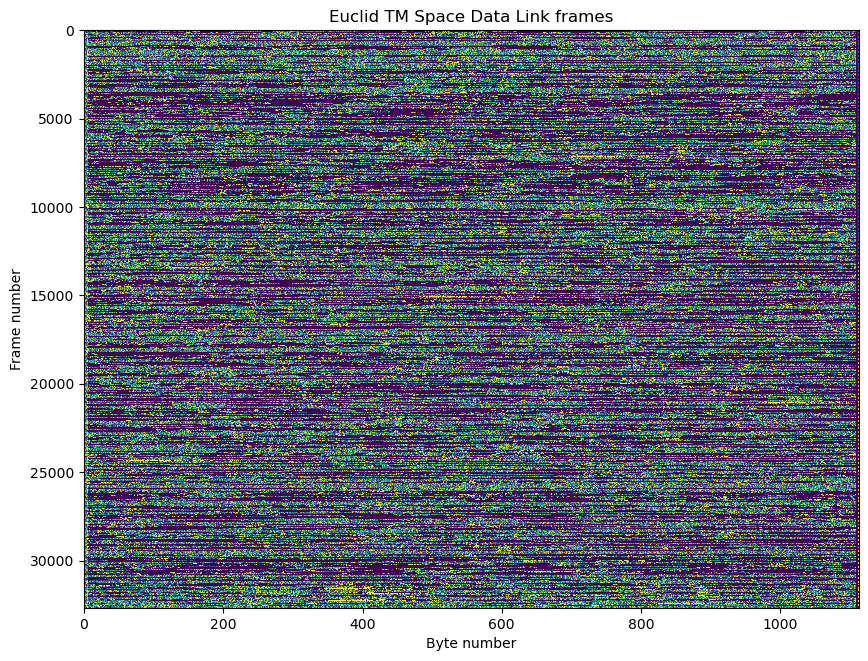

In [14]:
plt.figure(figsize=(10, 7.5))
plt.imshow(frames, aspect='auto', interpolation='none')
plt.title('Euclid TM Space Data Link frames')
plt.xlabel('Byte number')
plt.ylabel('Frame number');

In [15]:
mcfc_unwrap = np.empty(frames.shape[0], 'int')
last = 0
for j in range(frames.shape[0]):
    mcfc_unwrap[j] = (mcfc[j] + (last // 256) * 256
                      if last % 256 < mcfc[j]
                      else mcfc[j] + (last // 256 + 1) * 256)
    last = mcfc_unwrap[j]

In [16]:
# correct timestamps accounting for missed frames
lost_times = np.concatenate(([0], np.diff(mcfc_unwrap) - 1)).astype('float')
lost_times[frames_timestamp < frames_lowrate_timestamp_offset] *= frame_duration_highrate
lost_times[frames_timestamp >= frames_lowrate_timestamp_offset] *= frame_duration_lowrate
# but ignore frames lost during the modulation change
# (these have already been accounted for by setting the initial timestamp for the
# low rate frames)
lost_times[np.abs(frames_timestamp - frames_lowrate_timestamp_offset) < 30] = 0
lost_times = np.cumsum(lost_times)
frames_timestamp_corrected = frames_timestamp + lost_times

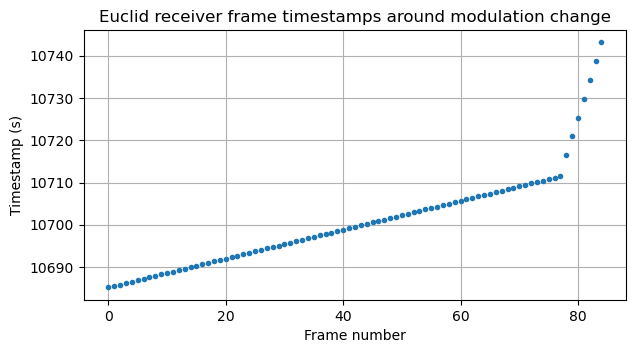

In [17]:
sel = np.abs(frames_timestamp_corrected - frames_lowrate_timestamp_offset) < 30
plt.plot(frames_timestamp_corrected[sel], '.')
plt.grid()
plt.title('Euclid receiver frame timestamps around modulation change')
plt.xlabel('Frame number')
plt.ylabel('Timestamp (s)');

In [18]:
t_frame = (np.datetime64(np.datetime64('2023-07-02T06:58:19.138'))
           + frames_timestamp_corrected * 1e9 * np.timedelta64(1, 'ns'))

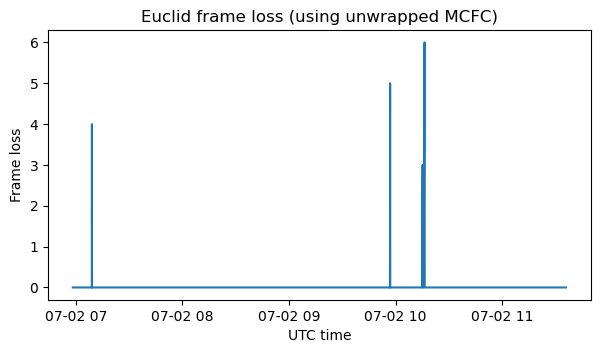

In [19]:
plt.plot(t_frame[1:], np.diff(mcfc_unwrap) - 1)
plt.title('Euclid frame loss (using unwrapped MCFC)')
plt.xlabel('UTC time')
plt.ylabel('Frame loss');

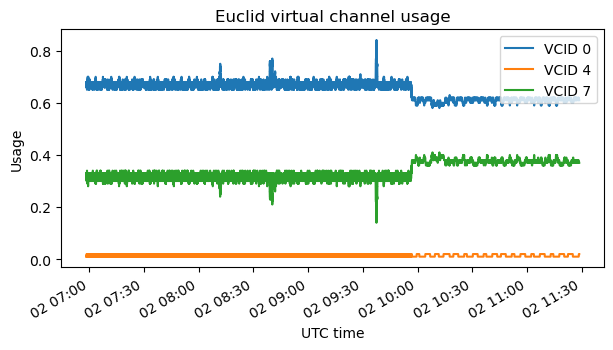

In [20]:
navg = 100
for v in sorted(set(vcid)):
    plt.plot(t_frame[:-navg+1], np.convolve(np.ones(navg)/navg, vcid == v, mode='valid'), label=f'VCID {v}')
plt.legend()
plt.title('Euclid virtual channel usage')
plt.ylabel('Usage')
plt.xlabel('UTC time')
plt.gcf().autofmt_xdate();

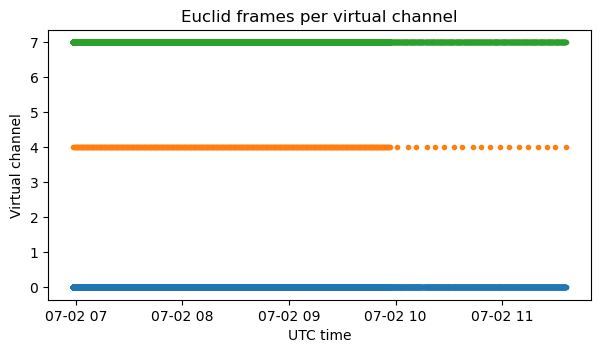

In [21]:
for v in sorted(set(vcid)):
    plt.plot(t_frame[vcid == v], np.ones(np.sum(vcid == v)) * v, '.')
plt.ylabel('Virtual channel')
plt.xlabel('UTC time')
plt.title('Euclid frames per virtual channel');

# VC0

Virtual channel 0 contains CCSDS Space Packets. There are several APIDs in use. All the APIDs, except APID 0, contain PUS packets following [ECSS-E-70-41A](https://cwe.ccsds.org/moims/docs/Work%20Completed%20(Closed%20WGs)/Packet%20Utilization%20Standard%20Birds%20of%20a%20Feather/Meeting%20Materials/200909%20Background/ECSS-E-70-41A(30Jan2003).pdf) (PUS version number 1).

Regarding PUS packets:
- The packet sub-counter field is not present
- The destination ID field is 8 bits wide (it the value `0x00` or `0x01`)
- The time field is 48 bits wide and contains the number of `2**(-16)` seconds since an epoch set at some point on the day of launch
- The spare field is not present

APID 0 contains spacecraft time source packets (these do not have a PUS header).

In [22]:
vc0_packets = list(ccsds.extract_space_packets(tm, 0x2a8, 0))
vc0_headers = [ccsds.SpacePacketPrimaryHeader.parse(p) for p in vc0_packets]

/home/daniel/euclid/ccsds.py:93: UserWarning: [Space Packet extractor Spacecraft 680 VC 0] Broken stream. Last frame count 198, current frame count 201
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
/home/daniel/euclid/ccsds.py:93: UserWarning: [Space Packet extractor Spacecraft 680 VC 0] Broken stream. Last frame count 5, current frame count 9
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
/home/daniel/euclid/ccsds.py:93: UserWarning: [Space Packet extractor Spacecraft 680 VC 0] Broken stream. Last frame count 156, current frame count 160
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
/home/daniel/euclid/ccsds.py:93: UserW

In [23]:
vc0_headers[:5]

[Container(ccsds_version=0, packet_type=0, secondary_header_flag=True, APID=550, sequence_flags=3, packet_sequence_count_or_name=6416, data_length=598),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=True, APID=1312, sequence_flags=3, packet_sequence_count_or_name=6520, data_length=507),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=True, APID=771, sequence_flags=3, packet_sequence_count_or_name=10160, data_length=125),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=True, APID=771, sequence_flags=3, packet_sequence_count_or_name=10161, data_length=147),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=True, APID=550, sequence_flags=3, packet_sequence_count_or_name=6417, data_length=481)]

In [24]:
vc0_apids = collections.Counter([p.APID for p in vc0_headers])
vc0_apids

Counter({550: 39992,
         771: 13926,
         1312: 5356,
         0: 341,
         555: 244,
         533: 112,
         769: 32,
         534: 4,
         556: 3,
         512: 2})

In [25]:
collections.Counter([(p.APID, p.secondary_header_flag) for p in vc0_headers])

Counter({(550, True): 39992,
         (771, True): 13926,
         (1312, True): 5356,
         (0, False): 341,
         (555, True): 244,
         (533, True): 112,
         (769, True): 32,
         (534, True): 4,
         (556, True): 3,
         (512, True): 2})

In [26]:
for apid in sorted(vc0_apids):
    print('APID', apid)
    print('data_lengths', collections.Counter([p.data_length for p in vc0_headers if p.APID == apid]))

APID 0
data_lengths Counter({8: 341})
APID 512
data_lengths Counter({15: 2})
APID 533
data_lengths Counter({15: 64, 1007: 8, 1005: 8, 1006: 6, 826: 6, 197: 4, 1017: 4, 217: 4, 321: 4, 913: 4})
APID 534
data_lengths Counter({15: 4})
APID 550
data_lengths Counter({598: 10711, 481: 10711, 78: 2678, 424: 1341, 473: 1339, 813: 1339, 180: 1339, 593: 1338, 93: 1071, 537: 1039, 422: 1038, 323: 1037, 315: 1037, 692: 1036, 358: 670, 237: 670, 391: 669, 72: 669, 409: 64, 433: 64, 54: 64, 666: 64, 15: 4})
APID 555
data_lengths Counter({15: 240, 926: 2, 622: 2})
APID 556
data_lengths Counter({15: 2, 21: 1})
APID 769
data_lengths Counter({21: 32})
APID 771
data_lengths Counter({125: 5356, 198: 5356, 147: 1072, 412: 1071, 129: 357, 269: 179, 258: 179, 245: 178, 140: 178})
APID 1312
data_lengths Counter({507: 5356})


In [27]:
vc0_by_apid = {apid: [p for p, h in zip(vc0_packets, vc0_headers) if h.APID == apid]
               for apid in vc0_apids}
vc0_t_by_apid = {apid: np.array([(to_timestamp_pus if apid != 0 else to_timestamp_apid0)(p)
                                 for p in vc0_by_apid[apid]])
                 for apid in vc0_apids}
vc0_pus_by_apid = {apid: [PUSHeader.parse(p[ccsds.SpacePacketPrimaryHeader.sizeof():])
                          for p in vc0_by_apid[apid]]
                   for apid in vc0_apids if apid not in [0]}
vc0_services_by_apid = {
    apid: collections.Counter([pus_service(p) for p in vc0_pus_by_apid[apid]])
    for apid in vc0_apids if apid not in [0]}

In [28]:
first_timestamp = np.min([vc0_t_by_apid[apid][0] for apid in vc0_apids])
t_frame[0] - (1e9 * first_timestamp) * np.timedelta64(1, 'ns')

numpy.datetime64('2023-07-01T08:07:02.266280640')

In [29]:
collections.Counter([(p.spare_flag, p.version_number, p.spare, p.destination_id)
                     for pus in vc0_pus_by_apid.values() for p in pus])

Counter({(False, 1, 0, 0): 59301, (False, 1, 0, 1): 370})

In [30]:
{apid: len([p for pus, p in zip(vc0_pus_by_apid[apid], vc0_by_apid[apid]) if pus.destination_id == 1])
 for apid in vc0_apids if apid != 0}

{550: 6, 1312: 0, 771: 0, 769: 0, 555: 244, 533: 112, 534: 4, 556: 2, 512: 2}

In [31]:
vc0_apids

Counter({550: 39992,
         771: 13926,
         1312: 5356,
         0: 341,
         555: 244,
         533: 112,
         769: 32,
         534: 4,
         556: 3,
         512: 2})

In [32]:
collections.Counter([(p.service_type, p.service_subtype) for pus in vc0_pus_by_apid.values() for p in pus if p.destination_id == 1])

Counter({(1, 1): 158, (1, 7): 158, (8, 2): 48, (11, 19): 4, (3, 25): 2})

In [33]:
collections.Counter([(p.service_type, p.service_subtype) for pus in vc0_pus_by_apid.values() for p in pus if p.destination_id == 0])

Counter({(3, 25): 58197, (3, 26): 1071, (5, 1): 33})

In [34]:
[(apid, p, a[16:-2].hex()) for apid in vc0_pus_by_apid for a, p in zip(vc0_by_apid[apid], vc0_pus_by_apid[apid])
 if p.destination_id == 1 and p.service_type == 3]

[(550,
  Container(spare_flag=False, version_number=1, spare=0, service_type=3, service_subtype=25, destination_id=1),
  '000a004f579f000152a00001400000004674000000000095000005d20000000080000000000005d20000000080000000ff444441ffffffff0632000006320000061f0000057b000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000080808080808080803017d0403017d0cf0200020b82050000308800003088000010101000100ff000000000000010c000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000fffff1effffffffffff0f0505f5050cff033f003c3f0202010141df3334419f3333500003000f03000000dd03030fff01733d0000004701510100030000014e'),
 (550,
  Container(spare_flag=False, version_num

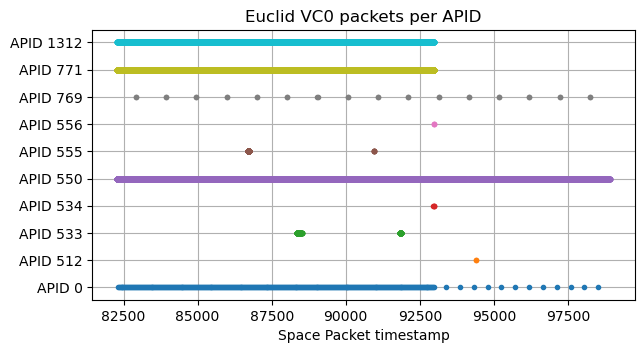

In [35]:
apid_keys = sorted(vc0_apids)
for j, apid in enumerate(apid_keys):
    plt.plot(vc0_t_by_apid[apid], np.ones(vc0_t_by_apid[apid].size) * j, '.'),
plt.yticks(np.arange(len(apid_keys)), [f'APID {a}' for a in apid_keys])
plt.grid()
plt.title('Euclid VC0 packets per APID')
plt.xlabel('Space Packet timestamp');

In [36]:
sec_avg = 100
tslices = 82200 + np.arange(4.6 * 3600 / sec_avg + 1) * sec_avg

In [37]:
vc0_packets_per_second = {
    apid:
    [np.sum((tslices[j] <= vc0_t_by_apid[apid]) & (vc0_t_by_apid[apid] < tslices[j+1])) / sec_avg
     for j in range(len(tslices) - 1)]
    for apid in vc0_apids}

vc0_bytes_per_second = {
    apid:
    [np.sum([len(p) for p, t in zip(vc0_by_apid[apid], vc0_t_by_apid[apid])
             if tslices[j] <= t < tslices[j+1]]) / sec_avg
     for j in range(len(tslices) - 1)]
    for apid in vc0_apids}

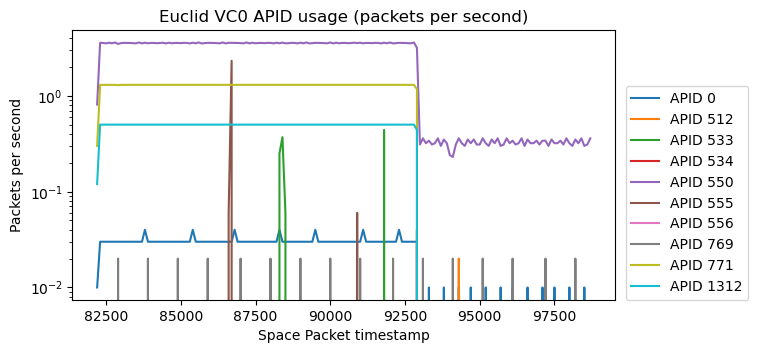

In [38]:
for j, apid in enumerate(sorted(vc0_packets_per_second)):
    plt.semilogy(tslices[:-1], vc0_packets_per_second[apid], label=f'APID {apid}',
                 linestyle='--' if j >= 10 else '-')
plt.legend(loc=[1.02,0])
plt.title('Euclid VC0 APID usage (packets per second)')
plt.ylabel('Packets per second')
plt.xlabel('Space Packet timestamp');

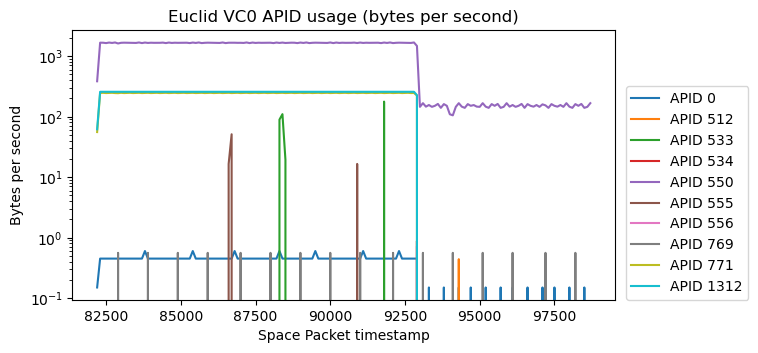

In [39]:
for j, apid in enumerate(sorted(vc0_bytes_per_second)):
    plt.semilogy(tslices[:-1], vc0_bytes_per_second[apid], label=f'APID {apid}',
                 linestyle='--' if j >= 10 else '-')
plt.legend(loc=[1.02,0])
plt.ylabel('Bytes per second')
plt.title('Euclid VC0 APID usage (bytes per second)')
plt.xlabel('Space Packet timestamp');

In [40]:
packet_crc = crc(16, 0x1021, 0xffff, 0x0, False, False)
packet_crc_ok_by_apid = {apid: 
                         [packet_crc.compute(list(p[:-2])) == struct.unpack('>H', p[-2:])[0]
                          for p in vc0_by_apid[apid]]
                         for apid in vc0_apids}
{apid: np.average(packet_crc_ok_by_apid[apid]) for apid in vc0_apids}

{550: 1.0,
 1312: 1.0,
 771: 1.0,
 0: 0.0,
 769: 1.0,
 555: 1.0,
 533: 1.0,
 534: 1.0,
 556: 1.0,
 512: 1.0}

## APID 0

APID 0 contains spacecraft time source packets reported every 64 frames and with a resolution of $2^{-24}$ seconds (7 bytes). These packets do not have a CRC-16 (unlike those used by JUICE).

In [41]:
[p[6:].hex() for p in vc0_by_apid[0]]

['062f0001417b117c10',
 '062f0001419be04d99',
 '062f000141bc00256f',
 '062f000141dccef6f8',
 '062f000141fd464ba8',
 '062f0001421e151d31',
 '062f0001423ee3eeb8',
 '062f0001425fb2c042',
 '062f000142802a14f2',
 '062f000142a1a7e02d',
 '062f000142c118be50',
 '062f000142e1e78fd9',
 '062f000143025ee489',
 '062f000143232db612',
 '062f00014343a50ac2',
 '062f0001436473dc4a',
 '062f000143859a2aaa',
 '062f000143a668fc35',
 '062f000143c688d40b',
 '062f000143e70028ba',
 '062f0001440826771e',
 '062f000144289dcbcc',
 '062f000144496c9d54',
 '062f00014469e3f205',
 '062f0001448b0a4067',
 '062f000144ab819517',
 '062f000144cba16ced',
 '062f000144ec703e76',
 '062f0001450ce79325',
 '062f0001452e0de188',
 '062f0001454e2db95c',
 '062f0001456efc8ae6',
 '062f0001459022d948',
 '062f000145b09a2df7',
 '062f000145d11182a7',
 '062f000145f188d757',
 '062f0001461257a8e0',
 '062f00014632cefd8f',
 '062f000146539dcf19',
 '062f000146746ca0a2',
 '062f000146953b722a',
 '062f000146b5b2c6da',
 '062f000146d62a1b89',
 '062f00014

In [42]:
collections.Counter([p[6:][:2].hex() for p in vc0_by_apid[0]])

Counter({'062f': 341})

In [43]:
rel_time_vc0 = vc0_t_by_apid[0] - vc0_t_by_apid[0][0]
sample_frames = (vcfc % 64 == 0) & (vcid == 0)
rel_time_frame = t_frame[sample_frames]
rel_time_frame = (rel_time_frame - rel_time_frame[0]) / np.timedelta64(1, 's')

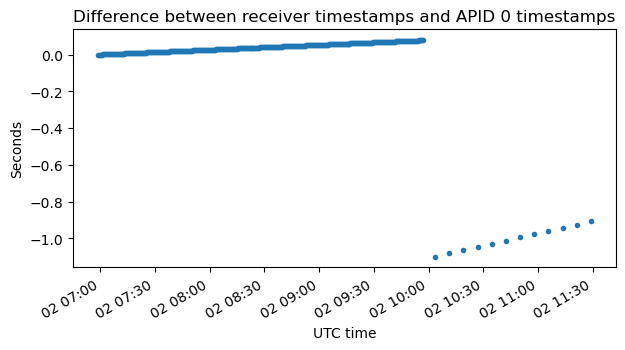

In [44]:
plt.plot(t_frame[sample_frames], rel_time_frame - rel_time_vc0, '.')
plt.gcf().autofmt_xdate()
plt.title('Difference between receiver timestamps and APID 0 timestamps')
plt.xlabel('UTC time')
plt.ylabel('Seconds');

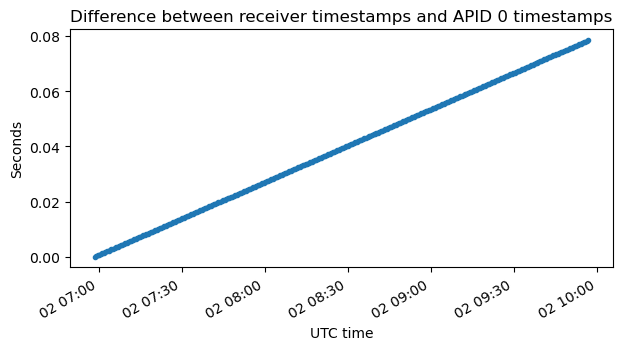

In [45]:
plt.plot(t_frame[sample_frames][:329], (rel_time_frame - rel_time_vc0)[:329], '.')
plt.gcf().autofmt_xdate()
plt.title('Difference between receiver timestamps and APID 0 timestamps')
plt.xlabel('UTC time')
plt.ylabel('Seconds');

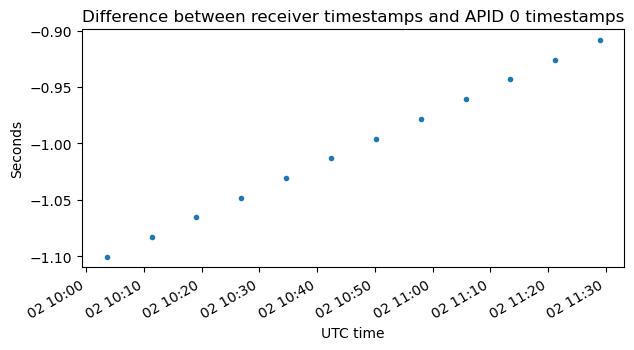

In [46]:
plt.plot(t_frame[sample_frames][329:], (rel_time_frame - rel_time_vc0)[329:], '.')
plt.gcf().autofmt_xdate()
plt.title('Difference between receiver timestamps and APID 0 timestamps')
plt.xlabel('UTC time')
plt.ylabel('Seconds');

In [47]:
# calculation of baudrate using spacecraft clock (high rate modulation)
frame_bits / ((vc0_t_by_apid[0][328] - vc0_t_by_apid[0][0])
              / (mcfc_unwrap[sample_frames][328] - mcfc_unwrap[sample_frames][0]))

59880.23961927853

In [48]:
# calculation of baudrate using spacecraft clock (low rate modulation)
frame_bits / ((vc0_t_by_apid[0][-1] - vc0_t_by_apid[0][329])
              / (mcfc_unwrap[sample_frames][-1] - mcfc_unwrap[sample_frames][329]))

4606.172278446184

## APID 512

In [49]:
vc0_services_by_apid[512]
# (1, 1) is telecommand acceptance report (telecommand verification service)
# (1, 7) is telecommand execution completed report (telecommand verification service)

Counter({(1, 1): 1, (1, 7): 1})

In [50]:
vc0_pus_by_apid[512]

[Container(spare_flag=False, version_number=1, spare=0, service_type=1, service_subtype=1, destination_id=1),
 Container(spare_flag=False, version_number=1, spare=0, service_type=1, service_subtype=7, destination_id=1)]

In [51]:
service1_payloads_apid512 = [ccsds.SpacePacketPrimaryHeader.parse(a[16:-2] + b'\x00\x00')
                             for a in vc0_by_apid[512]]
service1_payloads_apid512

[Container(ccsds_version=0, packet_type=1, secondary_header_flag=True, APID=512, sequence_flags=3, packet_sequence_count_or_name=5950, data_length=0),
 Container(ccsds_version=0, packet_type=1, secondary_header_flag=True, APID=512, sequence_flags=3, packet_sequence_count_or_name=5950, data_length=0)]

In [52]:
vc0_t_by_apid[512] - first_timestamp

array([12112.23831177, 12112.23857117])

## APID 533

In [53]:
vc0_services_by_apid[533]
# (8, 2) belongs to function management service, but there is no subtype 2 in the PUS standard
# (1, 1) is telecommand acceptance report (telecommand verification service)
# (1, 7) is telecommand execution completed report (telecommand verification service)

Counter({(8, 2): 48, (1, 1): 32, (1, 7): 32})

In [54]:
vc0_pus_by_apid[533]

[Container(spare_flag=False, version_number=1, spare=0, service_type=1, service_subtype=1, destination_id=1),
 Container(spare_flag=False, version_number=1, spare=0, service_type=8, service_subtype=2, destination_id=1),
 Container(spare_flag=False, version_number=1, spare=0, service_type=8, service_subtype=2, destination_id=1),
 Container(spare_flag=False, version_number=1, spare=0, service_type=8, service_subtype=2, destination_id=1),
 Container(spare_flag=False, version_number=1, spare=0, service_type=1, service_subtype=7, destination_id=1),
 Container(spare_flag=False, version_number=1, spare=0, service_type=1, service_subtype=1, destination_id=1),
 Container(spare_flag=False, version_number=1, spare=0, service_type=8, service_subtype=2, destination_id=1),
 Container(spare_flag=False, version_number=1, spare=0, service_type=8, service_subtype=2, destination_id=1),
 Container(spare_flag=False, version_number=1, spare=0, service_type=1, service_subtype=7, destination_id=1),
 Container

In [55]:
service1_payloads_apid533 = [
    ccsds.SpacePacketPrimaryHeader.parse(a[-6:-2] + b'\x00\x00')
    for a, p in zip(vc0_by_apid[533], vc0_pus_by_apid[533])
    if p.service_type == 1]
service1_payloads_apid533

[Container(ccsds_version=0, packet_type=1, secondary_header_flag=True, APID=533, sequence_flags=3, packet_sequence_count_or_name=14114, data_length=0),
 Container(ccsds_version=0, packet_type=1, secondary_header_flag=True, APID=533, sequence_flags=3, packet_sequence_count_or_name=14114, data_length=0),
 Container(ccsds_version=0, packet_type=1, secondary_header_flag=True, APID=533, sequence_flags=3, packet_sequence_count_or_name=14115, data_length=0),
 Container(ccsds_version=0, packet_type=1, secondary_header_flag=True, APID=533, sequence_flags=3, packet_sequence_count_or_name=14115, data_length=0),
 Container(ccsds_version=0, packet_type=1, secondary_header_flag=True, APID=533, sequence_flags=3, packet_sequence_count_or_name=14116, data_length=0),
 Container(ccsds_version=0, packet_type=1, secondary_header_flag=True, APID=533, sequence_flags=3, packet_sequence_count_or_name=14116, data_length=0),
 Container(ccsds_version=0, packet_type=1, secondary_header_flag=True, APID=533, sequenc

In [56]:
vc0_t_by_apid[533] - first_timestamp

array([6066.1388855 , 6066.13954163, 6066.14073181, 6066.14128113,
       6066.14157104, 6067.14068604, 6067.14128113, 6067.14212036,
       6067.14242554, 6068.139328  , 6068.13990784, 6068.14100647,
       6068.1418457 , 6068.14221191, 6069.14009094, 6069.14080811,
       6069.14186096, 6069.14250183, 6070.13922119, 6070.13996887,
       6070.14070129, 6097.14089966, 6097.14120483, 6105.13993835,
       6105.14022827, 6124.13923645, 6124.13952637, 6131.14147949,
       6131.14176941, 6138.1388092 , 6138.13948059, 6138.14065552,
       6138.14122009, 6138.14151001, 6139.14004517, 6139.14064026,
       6139.14147949, 6139.14178467, 6140.13938904, 6140.13996887,
       6140.14108276, 6140.141922  , 6140.14228821, 6141.14083862,
       6141.14155579, 6141.14260864, 6141.14324951, 6142.13980103,
       6142.14056396, 6142.14128113, 6193.14073181, 6193.14100647,
       6200.13882446, 6200.13909912, 6208.13877869, 6208.13905334,
       6217.14022827, 6217.14050293, 6218.13916016, 6218.13987

In [57]:
[a[16:-2].hex()
 for a, p in zip(vc0_by_apid[533], vc0_pus_by_apid[533])
 if p.service_type == 8]

['0000054300370101078b0501078d0501078f05010a2a1a6a020108290501082b0501083305010821186103010a3705010a3905010a3b05010c321c72040108bb050108bd050108bf05010c301c70050108c1050108c3050108c50501020b124b060108c7050108c9050108cb050101051145070108cd050108cf050108d105010d351d75080108d3050108d5050108d705010c331c73090108d9050108db050108dd0501071f175f0a01082305010825050108270501010611460b01084105010843050108450501010711470c0108df050108e1050108e30501030e134e0d01092f05010931050109330501082018600e01093505010937050109390501020a124a0f01093b0501093d0501093f05010b2c1b6c10010941050109430501094505010c311c7111010947050109490501094b0501030c134c1201094d0501094f0501095105010a281a68130109530501095505010957050101041144140109590501095b0501095d0501030d134d150109ad050109af050109b1050106181658160109b3050109b5050109b70501030f134f170109b9050109bb050109bd0501061a165a180109bf050109c1050109c30501061b165b190109c5050109c7050109c90501082218621a0109cb050109cd050109cf0501082318631b0109d1050109d3050109d505010b2f1b6f1c0109d7050109

## APID 534

In [58]:
vc0_services_by_apid[534]
# (1, 1) is telecommand acceptance report (telecommand verification service)
# (1, 7) is telecommand execution completed report (telecommand verification service)

Counter({(1, 1): 2, (1, 7): 2})

In [59]:
vc0_pus_by_apid[534]

[Container(spare_flag=False, version_number=1, spare=0, service_type=1, service_subtype=1, destination_id=1),
 Container(spare_flag=False, version_number=1, spare=0, service_type=1, service_subtype=7, destination_id=1),
 Container(spare_flag=False, version_number=1, spare=0, service_type=1, service_subtype=1, destination_id=1),
 Container(spare_flag=False, version_number=1, spare=0, service_type=1, service_subtype=7, destination_id=1)]

In [60]:
service1_payloads_apid534 = [ccsds.SpacePacketPrimaryHeader.parse(a[16:-2] + b'\x00\x00')
                             for a in vc0_by_apid[534]]
service1_payloads_apid534

[Container(ccsds_version=0, packet_type=1, secondary_header_flag=True, APID=534, sequence_flags=3, packet_sequence_count_or_name=11636, data_length=0),
 Container(ccsds_version=0, packet_type=1, secondary_header_flag=True, APID=534, sequence_flags=3, packet_sequence_count_or_name=11636, data_length=0),
 Container(ccsds_version=0, packet_type=1, secondary_header_flag=True, APID=534, sequence_flags=3, packet_sequence_count_or_name=11637, data_length=0),
 Container(ccsds_version=0, packet_type=1, secondary_header_flag=True, APID=534, sequence_flags=3, packet_sequence_count_or_name=11637, data_length=0)]

In [61]:
vc0_t_by_apid[534] - first_timestamp

array([10684.03611755, 10686.53546143, 10710.23854065, 10715.53530884])

## APID 550

In [62]:
vc0_services_by_apid[550]
# (3, 25) is housekeeping parameter report (housekeeping and diagnostic data reporting service)
# (3, 26) is diagnostic parameter report (housekeeping and diagnostic data reporting service)
# (1, 1) is telecommand acceptance report (telecommand verification service)
# (1, 7) is telecommand execution completed report (telecommand verification service)

Counter({(3, 25): 38917, (3, 26): 1071, (1, 1): 2, (1, 7): 2})

In [63]:
apid550_hk_sids = collections.Counter(
    a[16:18].hex() for a, p in zip(vc0_by_apid[550], vc0_pus_by_apid[550])
    if p.service_type == 3 and p.service_subtype == 25
)
apid550_hk_sids

Counter({'0048': 10711,
         '0043': 10711,
         '000d': 2678,
         '000a': 1341,
         '000f': 1339,
         '0010': 1339,
         '0018': 1339,
         '0014': 1338,
         '0000': 1039,
         '0001': 1038,
         '0005': 1037,
         '0006': 1037,
         '0040': 1036,
         '000b': 670,
         '004b': 670,
         '0008': 669,
         '0009': 669,
         '0003': 64,
         '0004': 64,
         '0007': 64,
         '0002': 64})

/tmp/ipykernel_25421/2169586510.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(8, 6))


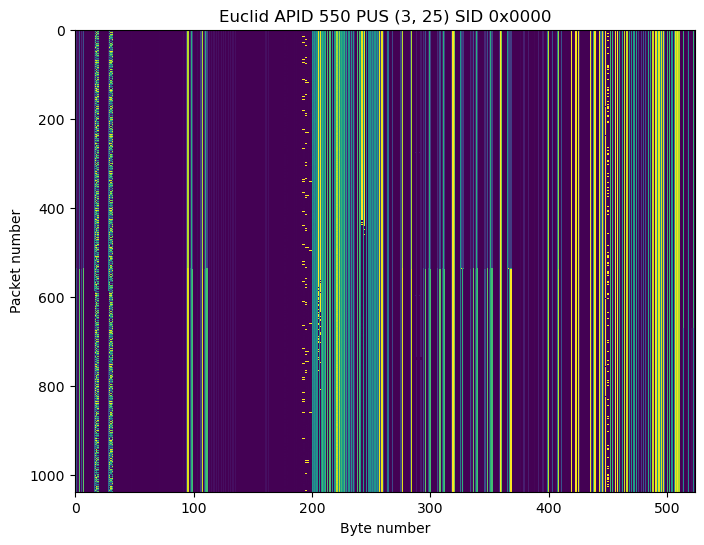

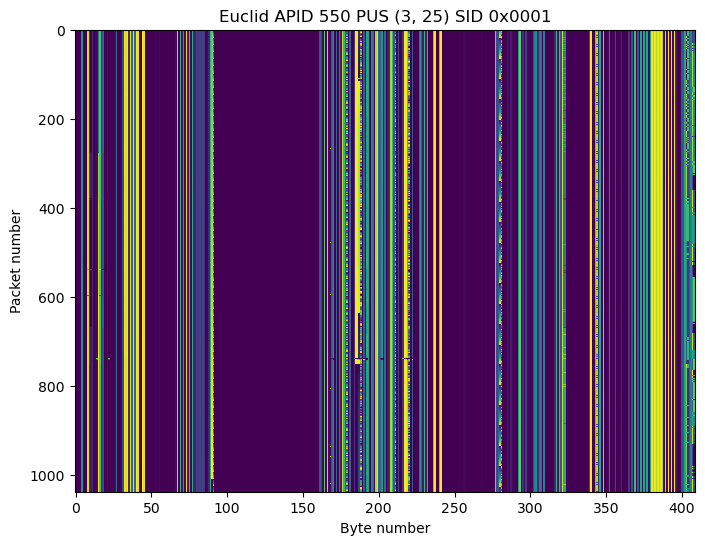

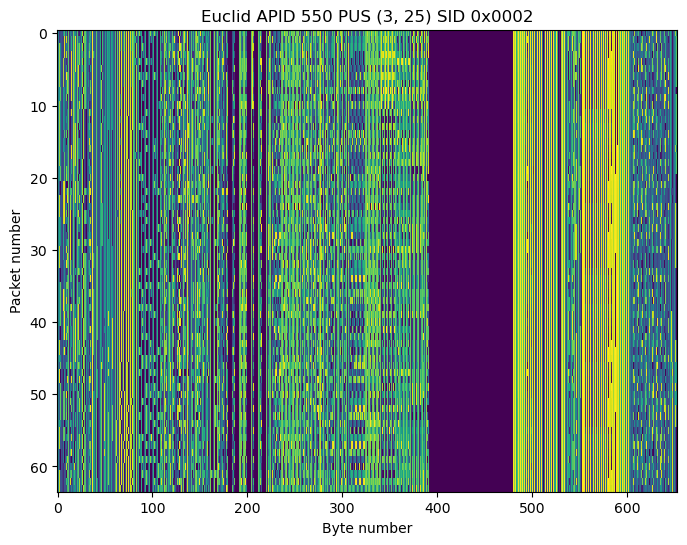

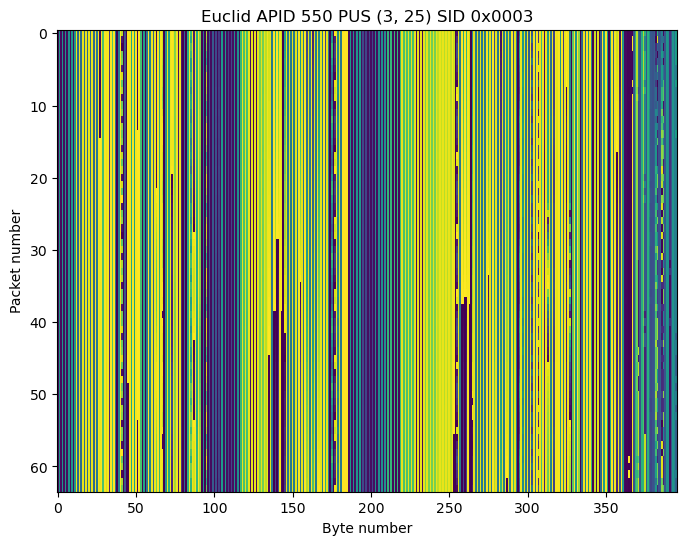

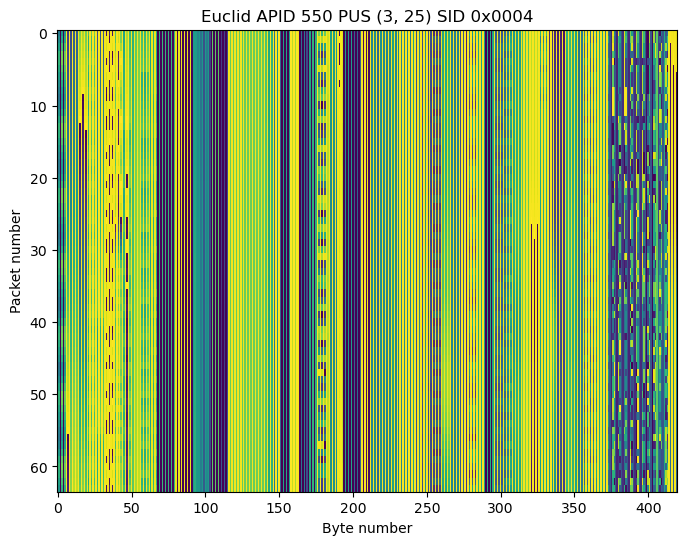

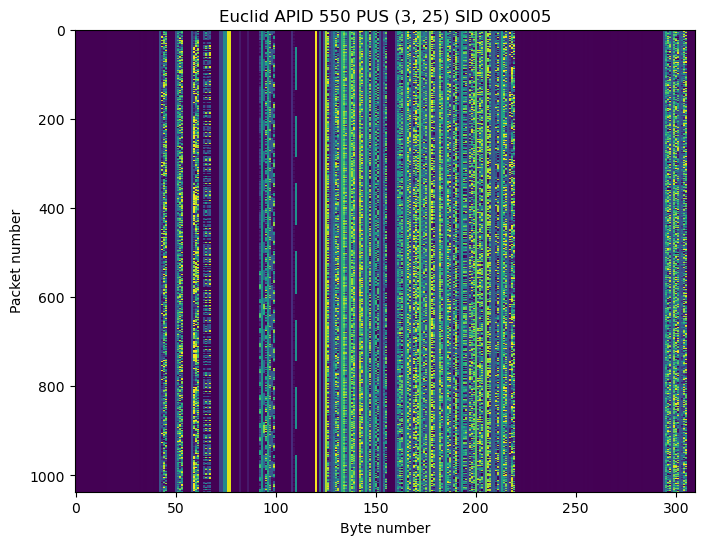

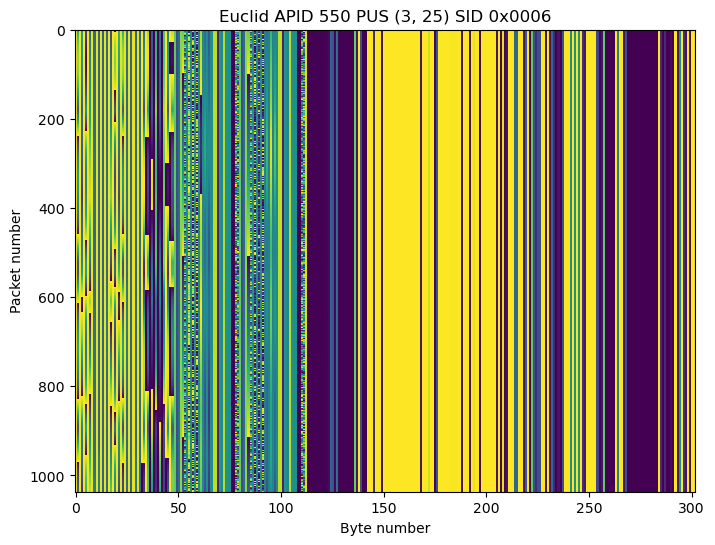

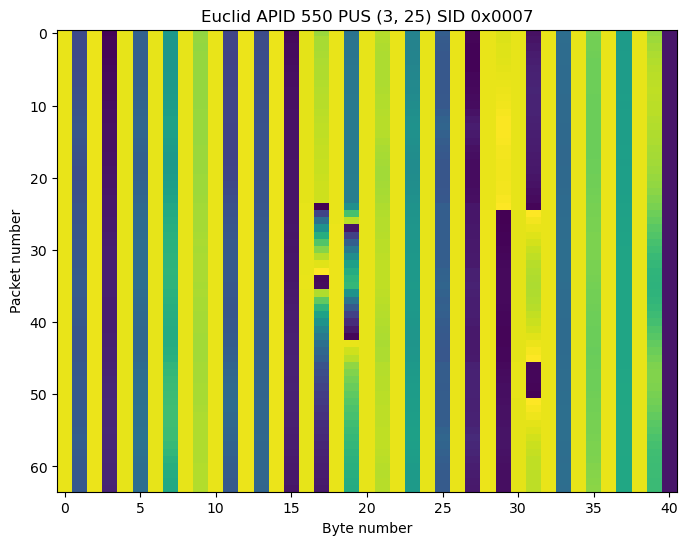

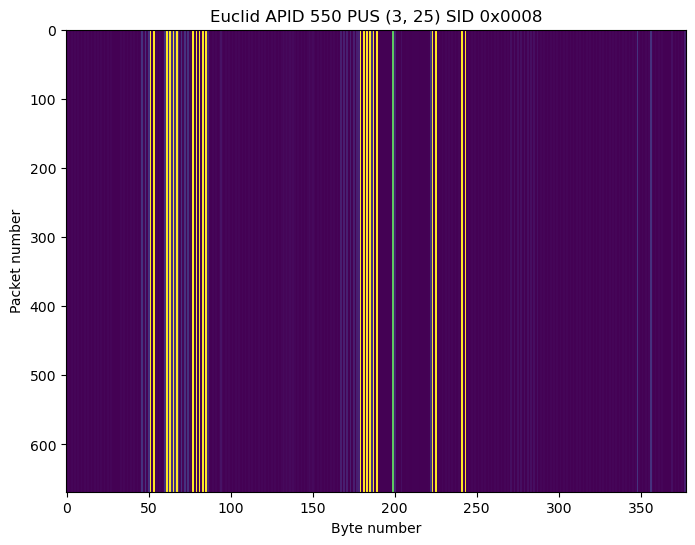

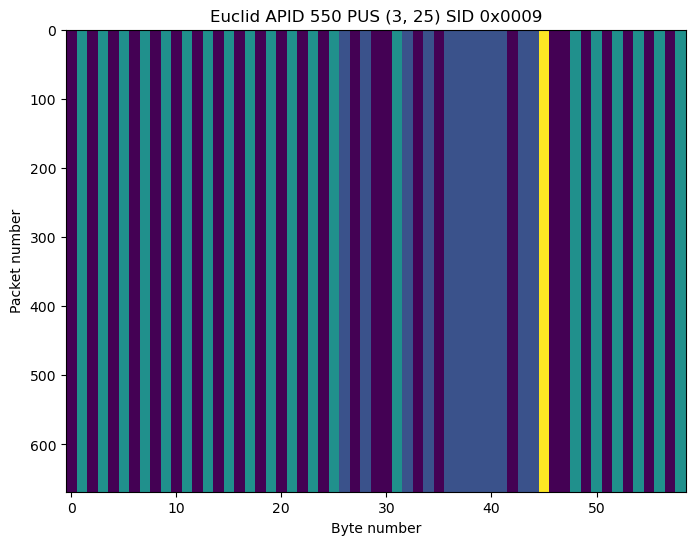

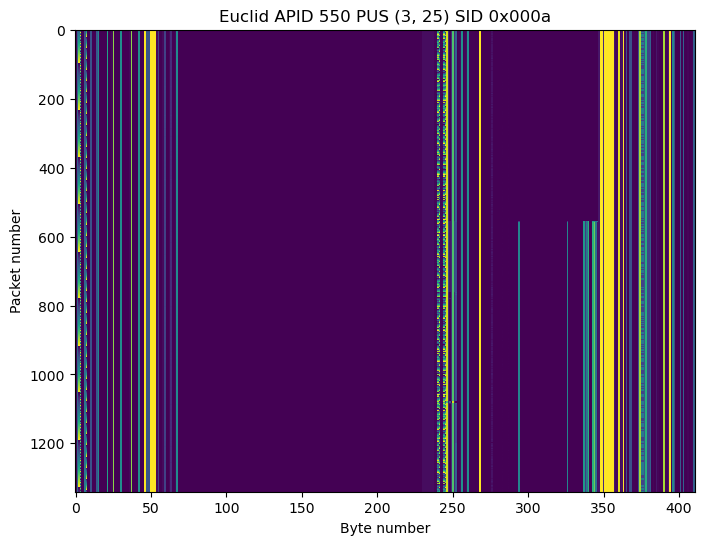

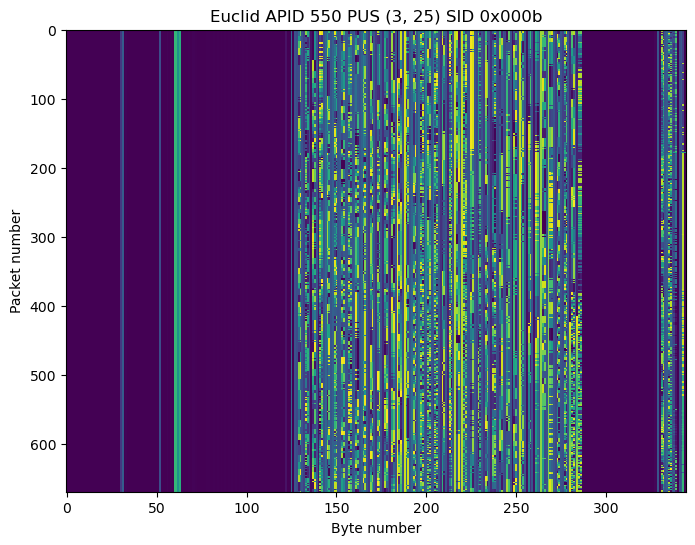

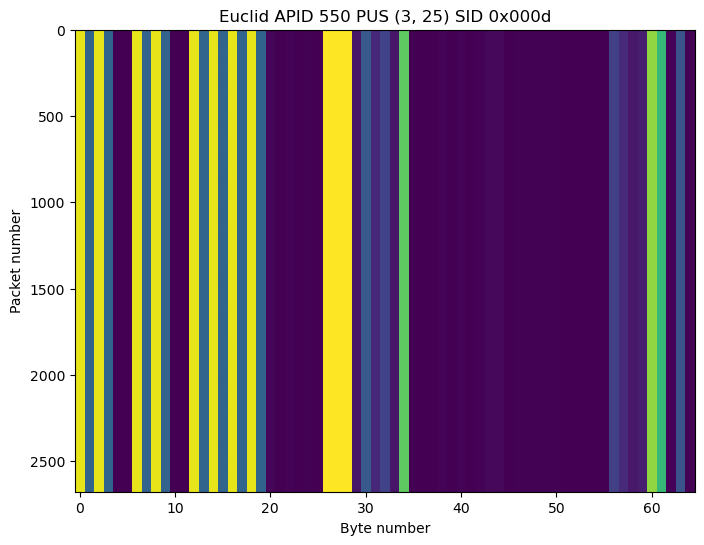

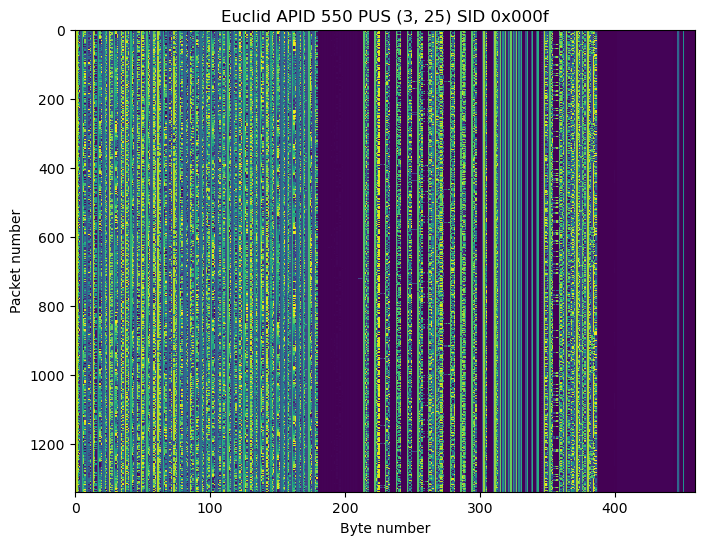

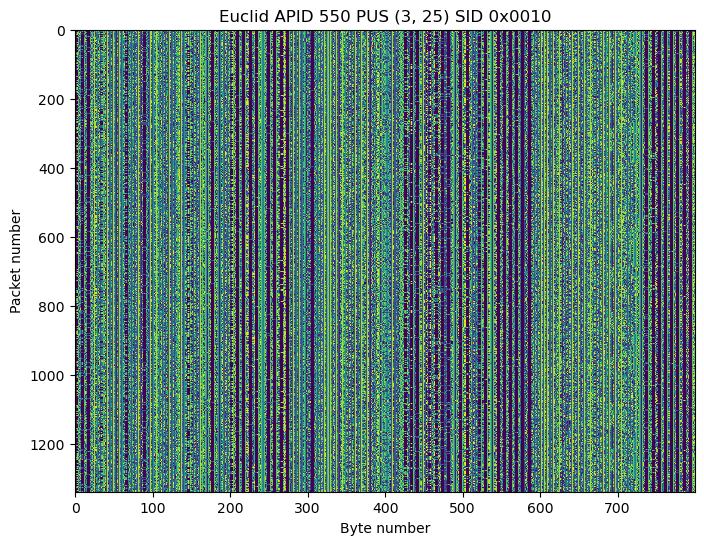

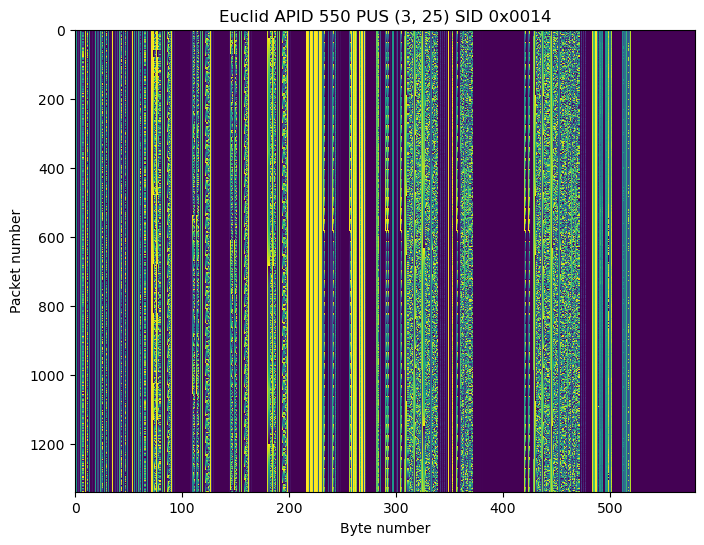

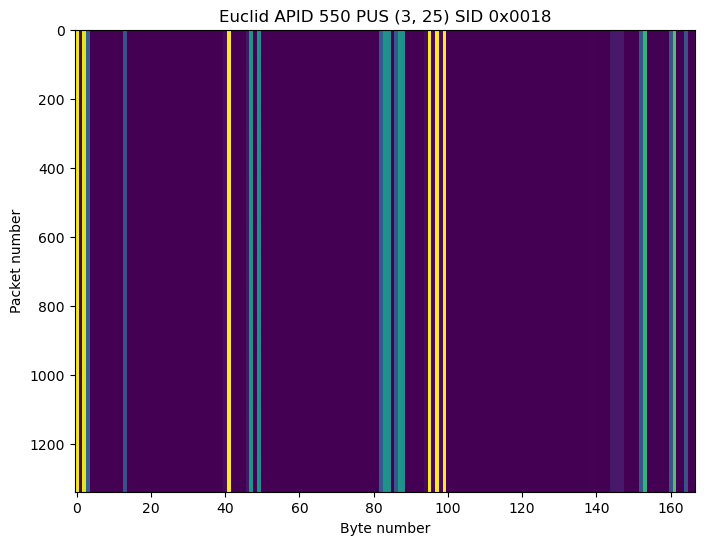

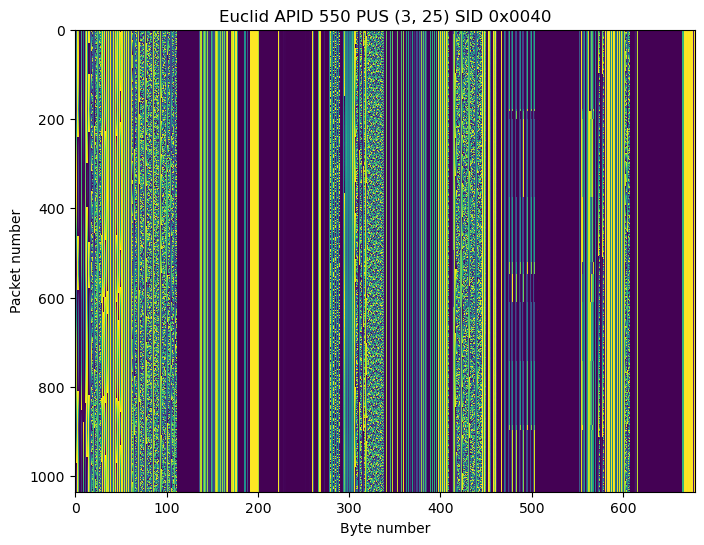

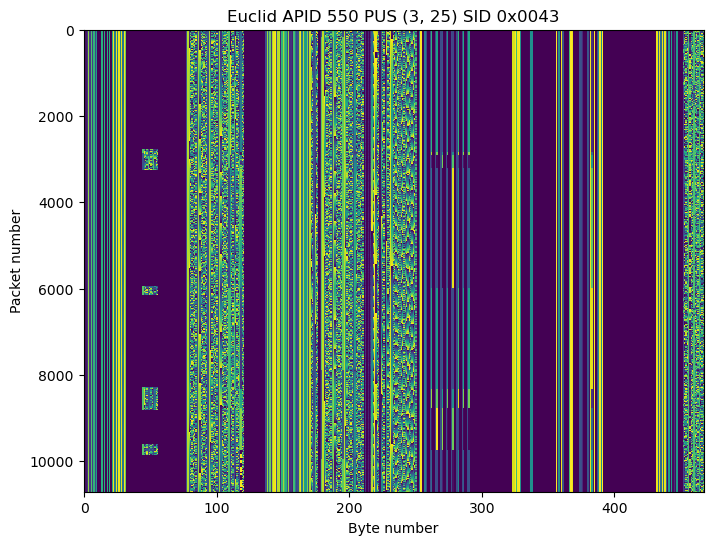

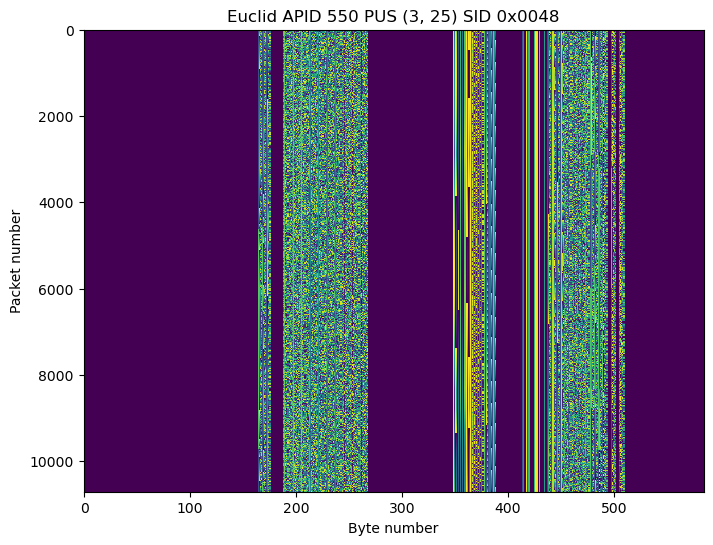

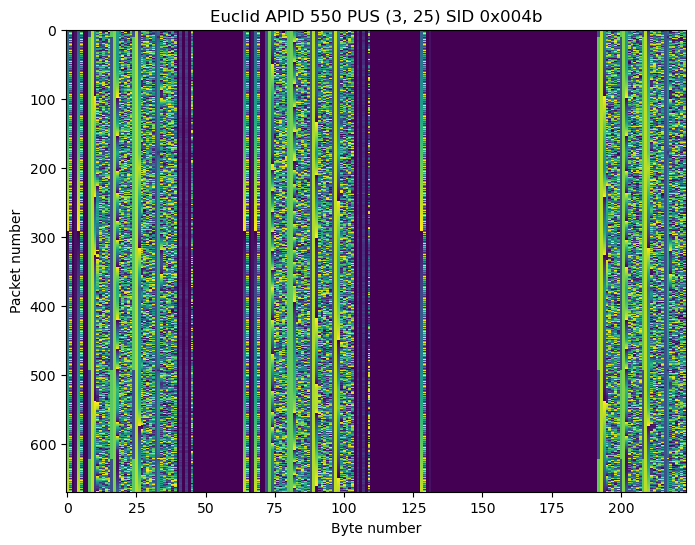

In [64]:
for sid in sorted(apid550_hk_sids):
    apid550_sid = np.array([np.frombuffer(a[18:-2], 'uint8')
                            for a, p in zip(vc0_by_apid[550], vc0_pus_by_apid[550])
                            if a[16:18].hex() == sid and p.service_type == 3 and p.service_subtype == 25])
    plt.figure(figsize=(8, 6))
    plt.imshow(apid550_sid, aspect='auto', interpolation='none')
    plt.title(f'Euclid APID 550 PUS (3, 25) SID 0x{sid}')
    plt.xlabel('Byte number')
    plt.ylabel('Packet number')

In [65]:
apid550_diag_sids = collections.Counter(
    a[16:18].hex() for a, p in zip(vc0_by_apid[550], vc0_pus_by_apid[550])
    if p.service_type == 3 and p.service_subtype == 26
)
apid550_diag_sids

Counter({'003d': 1071})

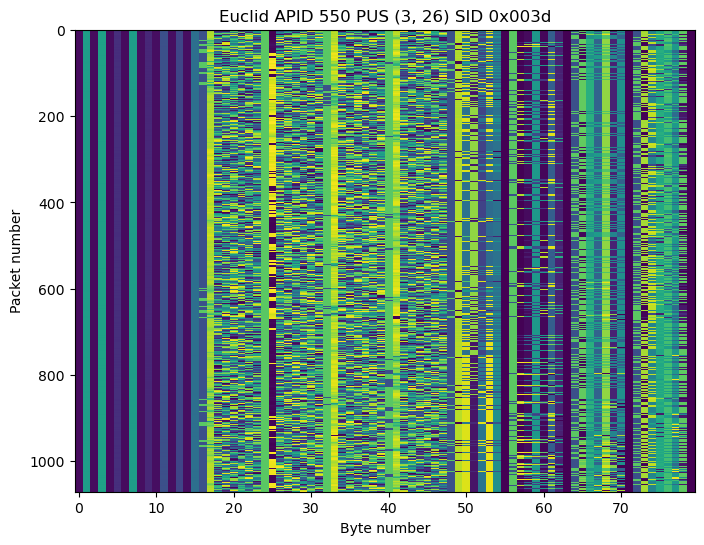

In [66]:
for sid in sorted(apid550_diag_sids):
    apid550_sid = np.array([np.frombuffer(a[18:-2], 'uint8')
                            for a, p in zip(vc0_by_apid[550], vc0_pus_by_apid[550])
                            if a[16:18].hex() == sid and p.service_type == 3 and p.service_subtype == 26])
    plt.figure(figsize=(8, 6))
    plt.imshow(apid550_sid, aspect='auto', interpolation='none')
    plt.title(f'Euclid APID 550 PUS (3, 26) SID 0x{sid}')
    plt.xlabel('Byte number')
    plt.ylabel('Packet number')

In [67]:
service1_payloads_apid550 = [
    ccsds.SpacePacketPrimaryHeader.parse(a[-6:-2] + b'\x00\x00')
    for a, p in zip(vc0_by_apid[550], vc0_pus_by_apid[550])
    if p.service_type == 1]
service1_payloads_apid550

[Container(ccsds_version=0, packet_type=1, secondary_header_flag=True, APID=550, sequence_flags=3, packet_sequence_count_or_name=6268, data_length=0),
 Container(ccsds_version=0, packet_type=1, secondary_header_flag=True, APID=550, sequence_flags=3, packet_sequence_count_or_name=6268, data_length=0),
 Container(ccsds_version=0, packet_type=1, secondary_header_flag=True, APID=550, sequence_flags=3, packet_sequence_count_or_name=6269, data_length=0),
 Container(ccsds_version=0, packet_type=1, secondary_header_flag=True, APID=550, sequence_flags=3, packet_sequence_count_or_name=6269, data_length=0)]

In [68]:
[t - first_timestamp for t, p in zip(vc0_t_by_apid[550], vc0_pus_by_apid[550])
 if p.service_type == 1]

[4411.141693115234, 4411.1429443359375, 8668.139389038086, 8668.140655517578]

## APID 555

In [69]:
vc0_services_by_apid[555]
# (1, 1) is telecommand acceptance report (telecommand verification service)
# (1, 7) is telecommand execution completed report (telecommand verification service)
# (11, 19) is command schedule status report (on-board operations scheduling service)

Counter({(1, 1): 120, (1, 7): 120, (11, 19): 4})

In [70]:
service1_payloads_apid555 = [
    ccsds.SpacePacketPrimaryHeader.parse(a[-6:-2] + b'\x00\x00')
    for a, p in zip(vc0_by_apid[555], vc0_pus_by_apid[555])
    if p.service_type == 1]
service1_payloads_apid555

[Container(ccsds_version=0, packet_type=1, secondary_header_flag=True, APID=555, sequence_flags=3, packet_sequence_count_or_name=16068, data_length=0),
 Container(ccsds_version=0, packet_type=1, secondary_header_flag=True, APID=555, sequence_flags=3, packet_sequence_count_or_name=16068, data_length=0),
 Container(ccsds_version=0, packet_type=1, secondary_header_flag=True, APID=555, sequence_flags=3, packet_sequence_count_or_name=16069, data_length=0),
 Container(ccsds_version=0, packet_type=1, secondary_header_flag=True, APID=555, sequence_flags=3, packet_sequence_count_or_name=16069, data_length=0),
 Container(ccsds_version=0, packet_type=1, secondary_header_flag=True, APID=555, sequence_flags=3, packet_sequence_count_or_name=16070, data_length=0),
 Container(ccsds_version=0, packet_type=1, secondary_header_flag=True, APID=555, sequence_flags=3, packet_sequence_count_or_name=16070, data_length=0),
 Container(ccsds_version=0, packet_type=1, secondary_header_flag=True, APID=555, sequenc

In [71]:
[t - first_timestamp for t, p in zip(vc0_t_by_apid[555], vc0_pus_by_apid[555])
 if p.service_type == 1]

[4410.139633178711,
 4410.140213012695,
 4411.144241333008,
 4412.1419677734375,
 4423.1424560546875,
 4423.144027709961,
 4424.140823364258,
 4424.1441650390625,
 4424.144439697266,
 4424.14469909668,
 4424.157958984375,
 4424.158294677734,
 4424.158584594727,
 4424.158828735352,
 4424.159088134766,
 4424.159332275391,
 4425.143127441406,
 4425.144378662109,
 4425.158355712891,
 4425.163726806641,
 4425.164031982422,
 4425.164276123047,
 4425.164535522461,
 4425.164779663086,
 4426.141342163086,
 4426.142593383789,
 4426.158843994141,
 4426.1591796875,
 4426.159423828125,
 4426.159683227539,
 4426.159927368164,
 4426.160171508789,
 4426.160430908203,
 4426.160675048828,
 4427.143310546875,
 4427.144546508789,
 4427.161483764648,
 4427.163345336914,
 4427.163619995117,
 4427.163864135742,
 4427.164123535156,
 4427.164367675781,
 4427.164627075195,
 4427.16487121582,
 4428.141860961914,
 4428.143127441406,
 4428.143707275391,
 4428.160217285156,
 4428.160507202148,
 4428.1607666015625,


In [72]:
def parse_schedule(packet):
    initial_field = packet[0]  # does not appear in the PUS standard
    print('initial_field =', initial_field)
    num_subschedules = struct.unpack('>H', packet[1:3])[0]
    subschedules = {}
    packet = packet[3:]
    for _ in range(num_subschedules):
        subsched_id = struct.unpack('>H', packet[:2])[0]
        subsched_enabled = packet[2]
        num_items = struct.unpack('>H', packet[3:5])[0]
        items = []
        packet = packet[5:]
        for _ in range(num_items):
            apid = packet[:2].hex()
            enabled = packet[2]
            packet = packet[3:]
            items.append((apid, enabled))
        subschedules[subsched_id] = (subsched_enabled, items)
    if len(packet) != 0:
        raise ValueError('unexpected data at end of packet')
    return subschedules

In [73]:
schedules = [parse_schedule(a[16:-2]) for a, p in zip(vc0_by_apid[555], vc0_pus_by_apid[555])
             if p.service_type == 11]

initial_field = 1
initial_field = 1
initial_field = 1
initial_field = 1


In [74]:
str(schedules[0])

"{1: (1, [('0000', 1), ('0001', 1), ('0100', 1), ('0200', 1), ('0201', 1), ('0202', 1), ('0212', 1), ('0213', 1), ('0214', 1), ('0215', 1), ('0216', 1), ('0217', 1), ('0218', 1), ('0226', 1), ('0227', 1), ('0228', 1), ('0229', 1), ('022a', 1), ('022b', 1), ('022c', 1), ('022d', 1), ('022e', 1), ('022f', 1), ('0230', 1), ('0231', 1), ('0234', 1), ('0235', 1), ('0236', 1), ('0237', 1), ('0270', 1), ('0301', 1), ('0302', 1), ('0303', 1), ('0304', 1), ('030c', 1), ('0341', 1), ('0342', 1), ('0343', 1), ('0344', 1), ('034c', 1), ('037c', 1), ('0400', 1), ('0410', 1), ('0510', 1), ('0511', 1), ('0520', 1), ('0700', 1), ('0701', 1), ('0776', 1)]), 2: (1, [('0000', 1), ('0001', 1), ('0100', 1), ('0200', 1), ('0201', 1), ('0202', 1), ('0212', 1), ('0213', 1), ('0214', 1), ('0215', 1), ('0216', 1), ('0217', 1), ('0218', 1), ('0226', 1), ('0227', 1), ('0228', 1), ('0229', 1), ('022a', 1), ('022b', 1), ('022c', 1), ('022d', 1), ('022e', 1), ('022f', 1), ('0230', 1), ('0231', 1), ('0234', 1), ('023

In [75]:
str(schedules[1])

"{7: (1, [('0000', 1), ('0001', 1), ('0100', 1), ('0200', 1), ('0201', 1), ('0202', 1), ('0212', 1), ('0213', 1), ('0214', 1), ('0215', 1), ('0216', 1), ('0217', 1), ('0218', 1), ('0226', 1), ('0227', 1), ('0228', 1), ('0229', 1), ('022a', 1), ('022b', 1), ('022c', 1), ('022d', 1), ('022e', 1), ('022f', 1), ('0230', 1), ('0231', 1), ('0234', 1), ('0235', 1), ('0236', 1), ('0237', 1), ('0270', 1), ('0301', 1), ('0302', 1), ('0303', 1), ('0304', 1), ('030c', 1), ('0341', 1), ('0342', 1), ('0343', 1), ('0344', 1), ('034c', 1), ('037c', 1), ('0400', 1), ('0410', 1), ('0510', 1), ('0511', 1), ('0520', 1), ('0700', 1), ('0701', 1), ('0776', 1)]), 8: (0, [('0000', 1), ('0001', 1), ('0100', 1), ('0200', 1), ('0201', 1), ('0202', 1), ('0212', 1), ('0213', 1), ('0214', 1), ('0215', 1), ('0216', 1), ('0217', 1), ('0218', 1), ('0226', 1), ('0227', 1), ('0228', 1), ('0229', 1), ('022a', 1), ('022b', 1), ('022c', 1), ('022d', 1), ('022e', 1), ('022f', 1), ('0230', 1), ('0231', 1), ('0234', 1), ('023

In [76]:
str(schedules[2]) == str(schedules[0])

True

In [77]:
np.where([a != b for a, b in zip(str(schedules[3]), str(schedules[1]))])

(array([652]),)

In [78]:
str(schedules[3])[640:660]

", 1)]), 8: (1, [('00"

In [79]:
str(schedules[1])[640:660]

", 1)]), 8: (0, [('00"

## APID 556

In [80]:
vc0_services_by_apid[556]
# (5, 1) is normal/progress report (event reporting service)
# (1, 1) is telecommand acceptance report (telecommand verification service)
# (1, 7) is telecommand execution completed report (telecommand verification service)

Counter({(5, 1): 1, (1, 1): 1, (1, 7): 1})

In [81]:
[a[16:-2].hex() for a in vc0_by_apid[556]]

['08030216080100000500', '1a2cfb0e', '1a2cfb0e']

In [82]:
service1_payloads_apid556 = [
    ccsds.SpacePacketPrimaryHeader.parse(a[-6:-2] + b'\x00\x00')
    for a, p in zip(vc0_by_apid[556], vc0_pus_by_apid[556])
    if p.service_type == 1]
service1_payloads_apid556

[Container(ccsds_version=0, packet_type=1, secondary_header_flag=True, APID=556, sequence_flags=3, packet_sequence_count_or_name=15118, data_length=0),
 Container(ccsds_version=0, packet_type=1, secondary_header_flag=True, APID=556, sequence_flags=3, packet_sequence_count_or_name=15118, data_length=0)]

In [83]:
vc0_t_by_apid[556] - first_timestamp

array([10699.032547  , 10710.14012146, 10710.14065552])

## APID 769

In [84]:
vc0_services_by_apid[769]
# (5, 1) is normal/progress report (event reporting service)

Counter({(5, 1): 32})

In [85]:
# The first 2 bytes are the RID (report ID)
[a[16:-2].hex() for a in vc0_by_apid[769]]

['025e0000000200000000',
 '025f0000000200000000',
 '025e0000000100000000',
 '025f0000000100000000',
 '025e0000000200000000',
 '025f0000000200000000',
 '025e0000000200000000',
 '025f0000000200000000',
 '025e0000000200000000',
 '025f0000000200000000',
 '025e0000000200000000',
 '025f0000000200000000',
 '025e0000000200000000',
 '025f0000000200000000',
 '025e0000000200000000',
 '025f0000000200000000',
 '025e0000000200000000',
 '025f0000000200000000',
 '025e0000000100000000',
 '025f0000000100000000',
 '025e0000000200000000',
 '025f0000000200000000',
 '025e0000000200000000',
 '025f0000000200000000',
 '025e0000000200000000',
 '025f0000000200000000',
 '025e0000000200000000',
 '025f0000000200000000',
 '025e0000000200000000',
 '025f0000000200000000',
 '025e0000000200000000',
 '025f0000000200000000']

## APID 771

In [86]:
vc0_services_by_apid[771]
# (3, 25) is housekeeping parameter report (housekeeping and diagnostic data reporting service)

Counter({(3, 25): 13926})

In [87]:
apid771_sids = collections.Counter(a[16:18].hex() for a in vc0_by_apid[771])
apid771_sids

Counter({'0002': 5356,
         '0003': 5356,
         '000c': 1072,
         '000d': 1071,
         '0008': 179,
         '0005': 179,
         '000a': 179,
         '0007': 178,
         '0004': 178,
         '0009': 178})

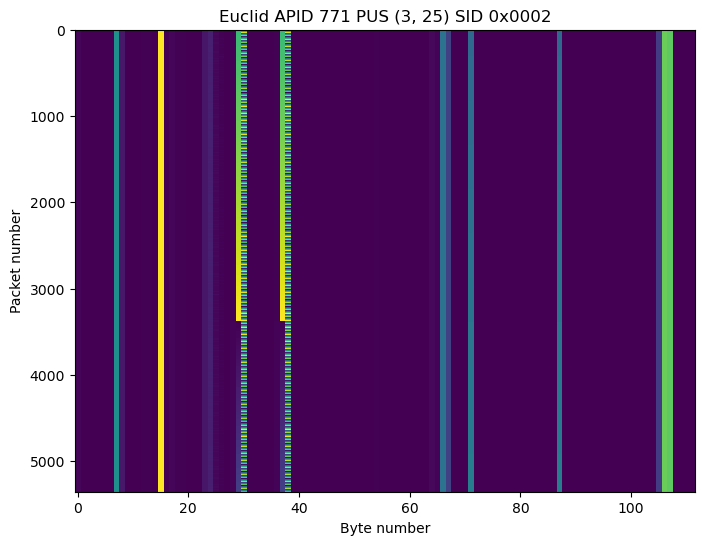

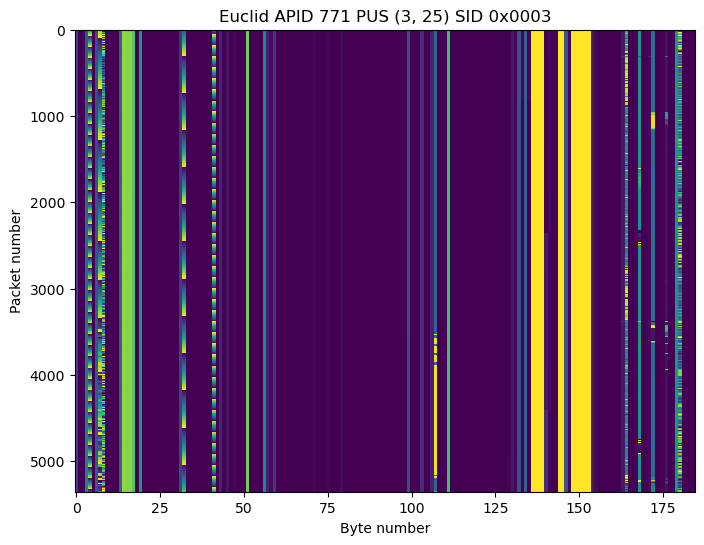

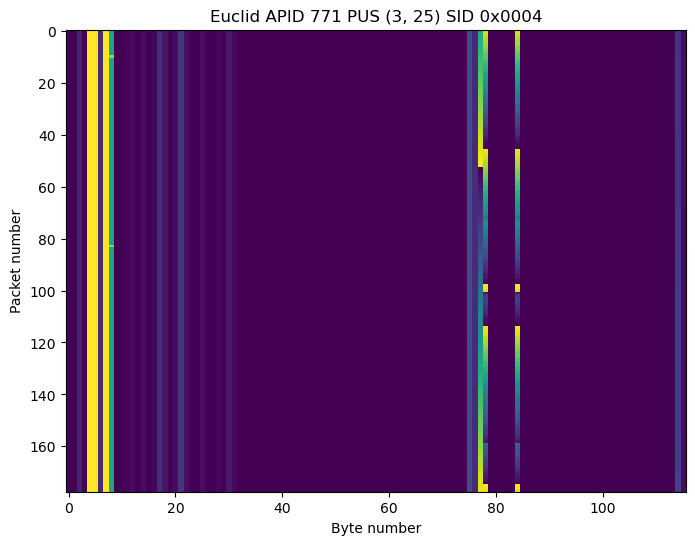

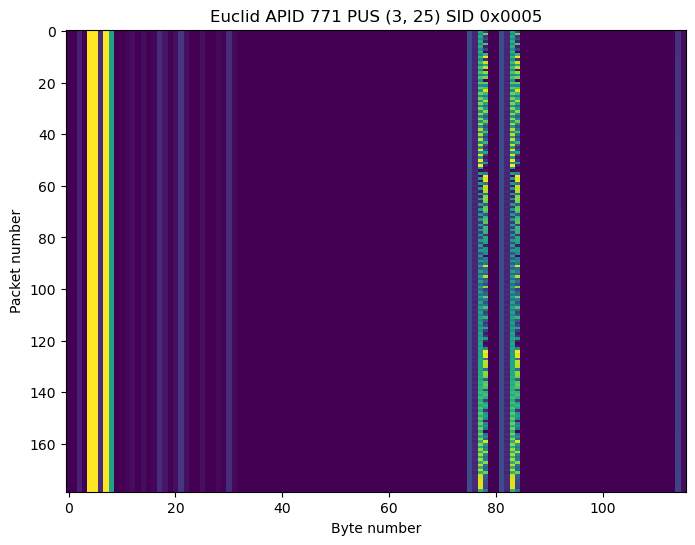

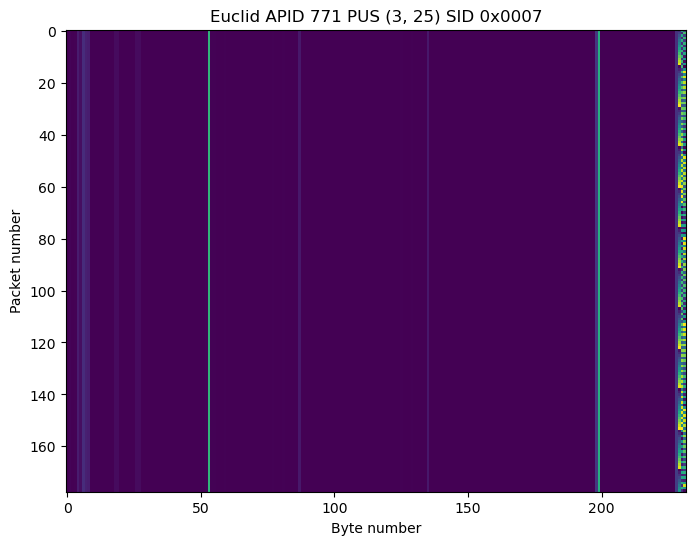

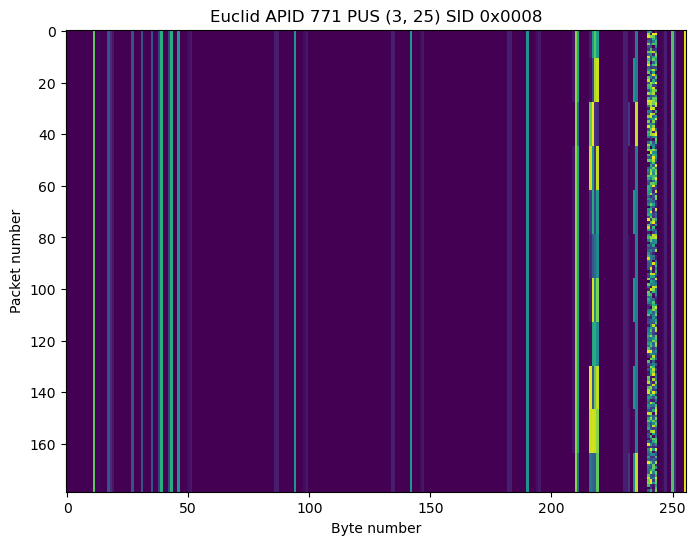

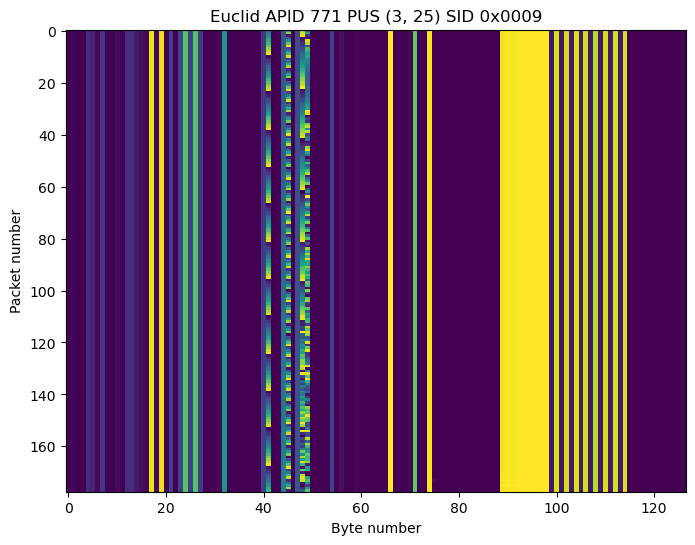

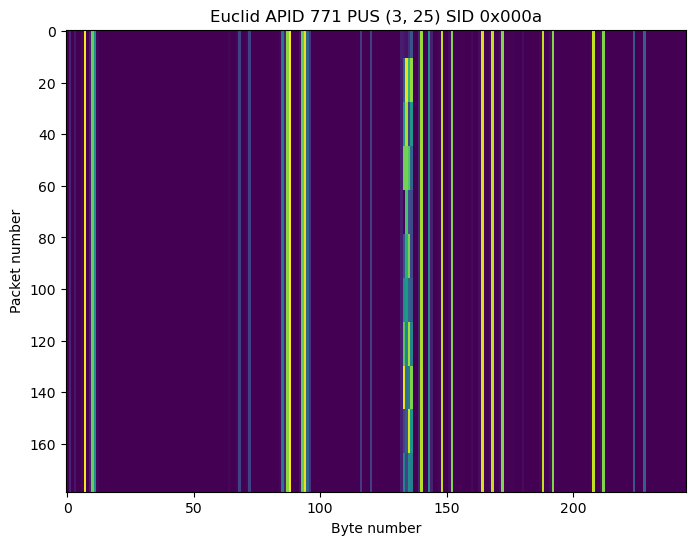

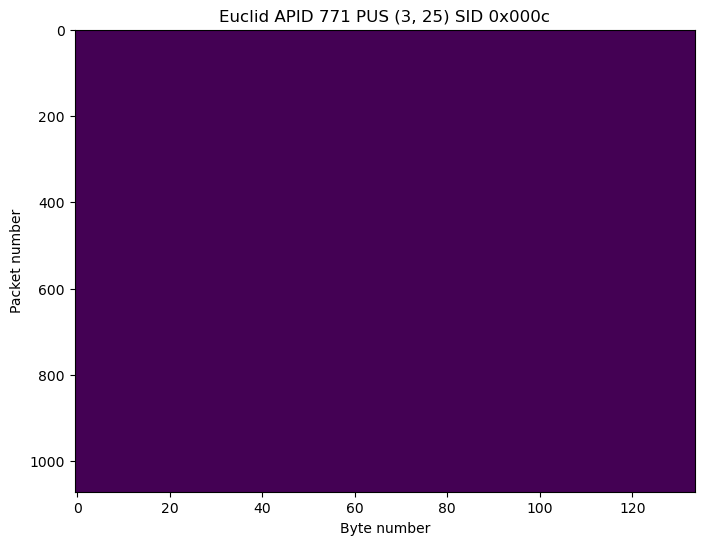

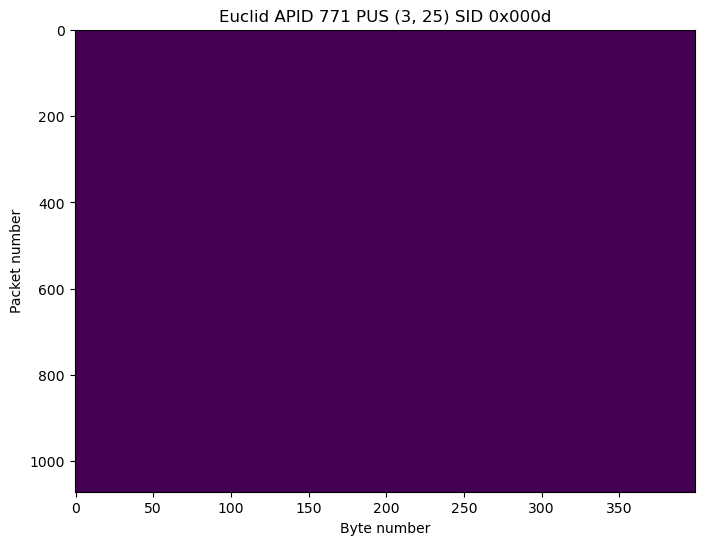

In [88]:
for sid in sorted(apid771_sids):
    apid771_sid = np.array([np.frombuffer(a[18:-2], 'uint8')
                            for a in vc0_by_apid[771] if a[16:18].hex() == sid])
    plt.figure(figsize=(8, 6))
    plt.imshow(apid771_sid, aspect='auto', interpolation='none')
    plt.title(f'Euclid APID 771 PUS (3, 25) SID 0x{sid}')
    plt.xlabel('Byte number')
    plt.ylabel('Packet number')

## APID 1312

In [89]:
vc0_services_by_apid[1312]
# (3, 25) is housekeeping parameter report (housekeeping and diagnostic data reporting service)

Counter({(3, 25): 5356})

In [90]:
apid1312_sids = collections.Counter(a[16:18].hex() for a in vc0_by_apid[1312])
apid1312_sids

Counter({'0001': 5356})

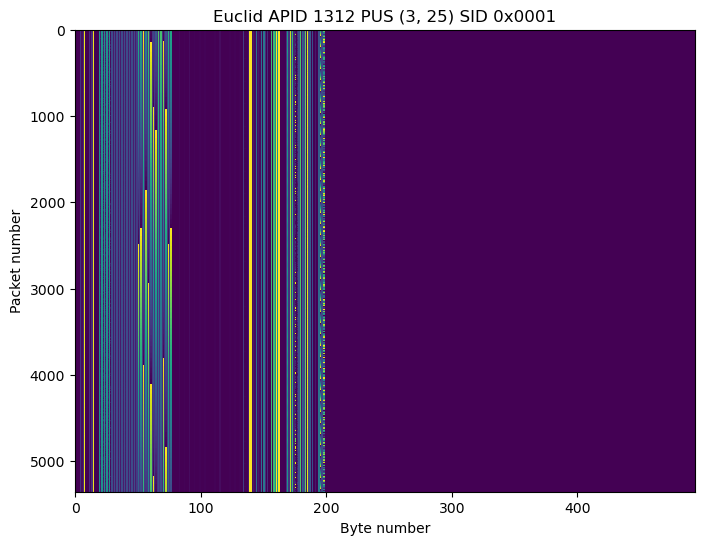

In [91]:
for sid in sorted(apid1312_sids):
    apid1312_sid = np.array([np.frombuffer(a[18:-2], 'uint8')
                             for a in vc0_by_apid[1312] if a[16:18].hex() == sid])
    plt.figure(figsize=(8, 6))
    plt.imshow(apid1312_sid, aspect='auto', interpolation='none')
    plt.title(f'Euclid APID 1312 PUS (3, 25) SID 0x{sid}')
    plt.xlabel('Byte number')
    plt.ylabel('Packet number')

# VC4

VC4 contains Space Packets from APID 15. These packets do not have a PUS header.

In [92]:
vc4_packets = list(ccsds.extract_space_packets(tm, 0x2a8, 4))
vc4_headers = [ccsds.SpacePacketPrimaryHeader.parse(p) for p in vc4_packets]

In [93]:
vc4_headers[:5]

[Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=15, sequence_flags=3, packet_sequence_count_or_name=15041, data_length=243),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=15, sequence_flags=3, packet_sequence_count_or_name=15042, data_length=243),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=15, sequence_flags=3, packet_sequence_count_or_name=15043, data_length=243),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=15, sequence_flags=3, packet_sequence_count_or_name=15044, data_length=243),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=15, sequence_flags=3, packet_sequence_count_or_name=15045, data_length=243)]

In [94]:
vc4_apids = collections.Counter([p.APID for p in vc4_headers])
vc4_apids

Counter({15: 2042})

In [95]:
for apid in sorted(vc4_apids):
    print('APID', apid)
    print('data_lengths', collections.Counter([p.data_length for p in vc4_headers if p.APID == apid]))

APID 15
data_lengths Counter({243: 2042})


In [96]:
vc4_by_apid = {apid: [p for p, h in zip(vc4_packets, vc4_headers) if h.APID == apid]
               for apid in vc4_apids}
apid15 = np.array([np.frombuffer(p, 'uint8') for p in vc4_by_apid[15]])

In [97]:
vc4_pus_by_apid = {apid: [PUSHeader.parse(p[ccsds.SpacePacketPrimaryHeader.sizeof():])
                          for p in vc4_by_apid[apid]]
                   for apid in vc4_apids if apid not in [0]}

In [98]:
vc4_pus_by_apid

{15: [Container(spare_flag=False, version_number=0, spare=2, service_type=253, service_subtype=2, destination_id=253),
  Container(spare_flag=False, version_number=0, spare=2, service_type=253, service_subtype=2, destination_id=253),
  Container(spare_flag=False, version_number=0, spare=2, service_type=253, service_subtype=2, destination_id=253),
  Container(spare_flag=False, version_number=0, spare=2, service_type=253, service_subtype=2, destination_id=253),
  Container(spare_flag=False, version_number=0, spare=2, service_type=253, service_subtype=2, destination_id=253),
  Container(spare_flag=False, version_number=0, spare=2, service_type=253, service_subtype=2, destination_id=253),
  Container(spare_flag=False, version_number=0, spare=2, service_type=253, service_subtype=2, destination_id=253),
  Container(spare_flag=False, version_number=0, spare=2, service_type=253, service_subtype=2, destination_id=253),
  Container(spare_flag=False, version_number=0, spare=2, service_type=253, s

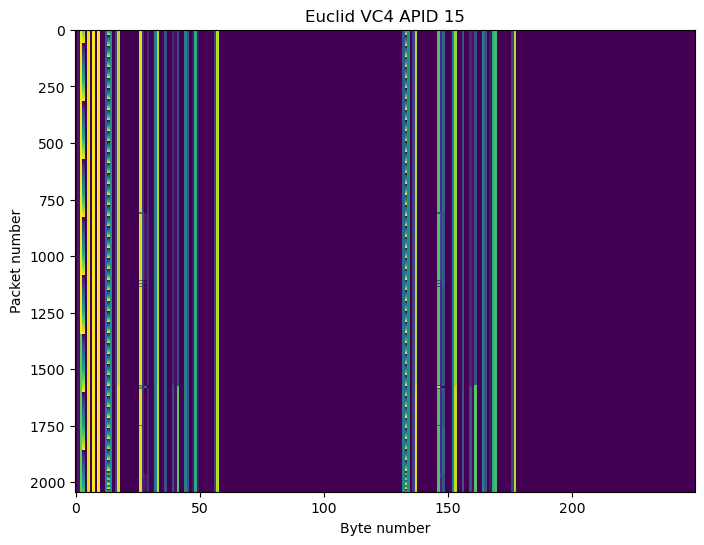

In [99]:
plt.figure(figsize=(8, 6))
plt.imshow(apid15, aspect='auto', interpolation='none')
plt.title('Euclid VC4 APID 15')
plt.xlabel('Byte number')
plt.ylabel('Packet number');

# VC7

VC7 is the idle APID. The payload of the frames is filled by a PN9 sequence in the same [way as for BepiColombo](https://destevez.net/2020/04/idle-data-in-bepicolombo-x-band-signal/).

In [100]:
vc7_frames = frames[vcid == 7]

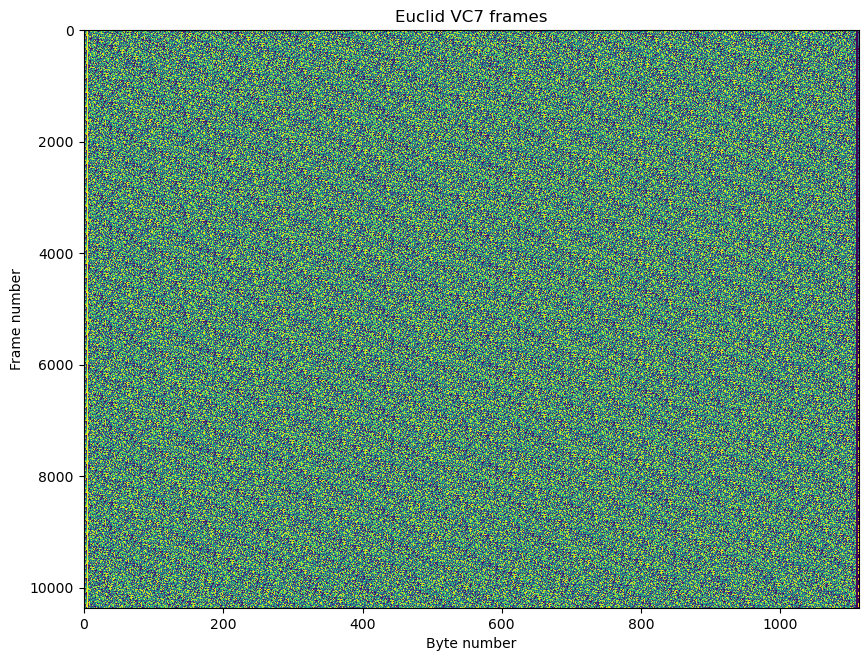

In [101]:
plt.figure(figsize=(10, 7.5))
plt.imshow(vc7_frames, aspect='auto', interpolation='none')
plt.title('Euclid VC7 frames')
plt.xlabel('Byte number')
plt.ylabel('Frame number');

In [102]:
lfsr = np.ones(9, dtype = 'uint8')
lfsr_out = np.empty(511, dtype = 'uint8')
for j in range(lfsr_out.size):
    out = lfsr[8] ^ lfsr[4]
    lfsr_out[j] = lfsr[8]
    lfsr = np.roll(lfsr, 1)
    lfsr[0] = out
    
def gen_idle_payload(vcfc):
    start = (8824 * vcfc) % 511
    lfsr_out_repeat = np.tile(lfsr_out, int(np.ceil(8824 / 511)) + 2)
    return bytes(np.packbits(lfsr_out_repeat[start:start+8824]))

for frame in tm:
    if frame.primary_header.virtual_channel_id == 7:
        assert frame.m_pdu_packet_zone == gen_idle_payload(frame.primary_header.virtual_channel_frame_count)

# CLCW

The CLCWs contained in the OCF (operation control field) alternate between VC1 and VC2 (frames with even master channel frame count report for VC1, and frames with odd master channel frame count report for VC2).

There is the following relation between the no RF available and no bit lock fields: no RF available implies no bit lock (this is to be expected).

In [103]:
clcw = [a.clcw for a in tm]

In [104]:
clcw[:4]

[Container(control_word_type=False, clcw_version_number=0, status_field=0, cop_in_effect=1, virtual_channel_identification=2, rsvd_spare=0, no_rf_avail=False, no_bit_lock=False, lock_out=False, wait=False, retransmit=False, farm_b_counter=0, rsvd_spare2=0, report_value=2),
 Container(control_word_type=False, clcw_version_number=0, status_field=0, cop_in_effect=1, virtual_channel_identification=1, rsvd_spare=0, no_rf_avail=False, no_bit_lock=False, lock_out=False, wait=False, retransmit=False, farm_b_counter=3, rsvd_spare2=0, report_value=95),
 Container(control_word_type=False, clcw_version_number=0, status_field=0, cop_in_effect=1, virtual_channel_identification=2, rsvd_spare=0, no_rf_avail=False, no_bit_lock=False, lock_out=False, wait=False, retransmit=False, farm_b_counter=0, rsvd_spare2=0, report_value=2),
 Container(control_word_type=False, clcw_version_number=0, status_field=0, cop_in_effect=1, virtual_channel_identification=1, rsvd_spare=0, no_rf_avail=False, no_bit_lock=False,

In [105]:
collections.Counter([(c.control_word_type, c.clcw_version_number, c.status_field, c.cop_in_effect,
                      c.rsvd_spare, c.rsvd_spare2, c.retransmit, c.lock_out, c.wait)
                     for c in clcw])

Counter({(False, 0, 0, 1, 0, 0, False, False, False): 32669})

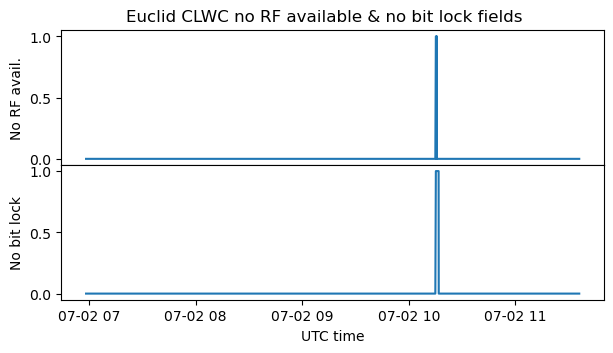

In [106]:
fig, axs = plt.subplots(2,1, sharex=True, sharey=True)
axs[0].plot(t_frame, [c.no_rf_avail for c in clcw])
axs[0].set_ylabel('No RF avail.')
axs[1].plot(t_frame, [c.no_bit_lock for c in clcw])
axs[1].set_ylabel('No bit lock')
plt.subplots_adjust(hspace=0)
plt.xlabel('UTC time')
plt.suptitle('Euclid CLWC no RF available & no bit lock fields', y=0.94);

In [107]:
all([not c.no_rf_avail or c.no_bit_lock for c in clcw])

True

In [108]:
collections.Counter([c.virtual_channel_identification for c in clcw])

Counter({2: 16335, 1: 16334})

In [109]:
collections.Counter((m % 2, c.virtual_channel_identification) for m, c in zip(mcfc, clcw))

Counter({(1, 2): 16335, (0, 1): 16334})

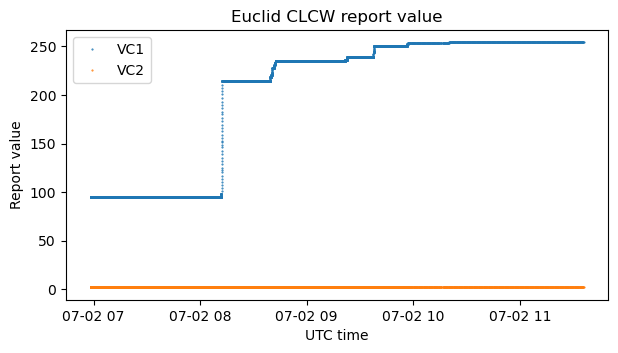

In [110]:
cvc = np.array([c.virtual_channel_identification for c in clcw])
report_vc1 = np.array([c.report_value for c in clcw if c.virtual_channel_identification == 1])
report_vc2 = np.array([c.report_value for c in clcw if c.virtual_channel_identification == 2])
plt.plot(t_frame[cvc == 1], report_vc1, '.', label='VC1', markersize=1)
plt.plot(t_frame[cvc == 2], report_vc2, '.', label='VC2', markersize=1)
plt.legend()
plt.title('Euclid CLCW report value')
plt.ylabel('Report value')
plt.xlabel('UTC time');

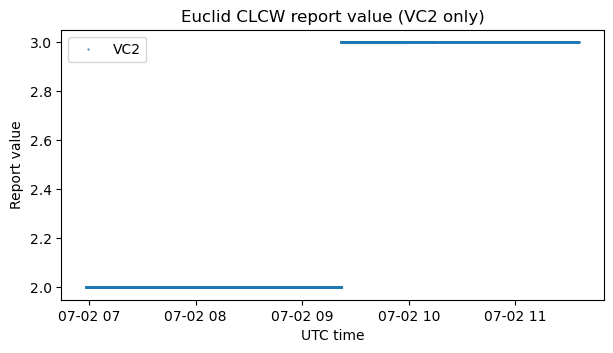

In [111]:
plt.plot(t_frame[cvc == 2], report_vc2, '.', label='VC2', markersize=1)
plt.legend()
plt.title('Euclid CLCW report value (VC2 only)')
plt.ylabel('Report value')
plt.xlabel('UTC time');

In [112]:
np.unique(report_vc2)

array([2, 3])

In [113]:
d = np.concatenate([[0], np.diff(report_vc1)])
d[d != 0]

array([1, 1, 1, 3, 3, 3, 3, 4, 3, 4, 2, 2, 4, 3, 3, 4, 3, 4, 3, 3, 1, 3,
       3, 4, 3, 3, 4, 3, 4, 3, 4, 3, 3, 4, 4, 3, 3, 3, 4, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [114]:
t_frame[cvc == 1][d != 0]

array(['2023-07-02T08:11:48.071630372', '2023-07-02T08:11:48.755132989',
       '2023-07-02T08:11:49.438635606', '2023-07-02T08:12:01.741682711',
       '2023-07-02T08:12:02.425185327', '2023-07-02T08:12:03.108687944',
       '2023-07-02T08:12:03.792190561', '2023-07-02T08:12:04.475693178',
       '2023-07-02T08:12:05.159195795', '2023-07-02T08:12:05.842698412',
       '2023-07-02T08:12:06.526201029', '2023-07-02T08:12:07.209703646',
       '2023-07-02T08:12:07.893206263', '2023-07-02T08:12:08.576708880',
       '2023-07-02T08:12:09.260211497', '2023-07-02T08:12:09.943714113',
       '2023-07-02T08:12:10.627216730', '2023-07-02T08:12:11.310719347',
       '2023-07-02T08:12:11.994221964', '2023-07-02T08:12:12.677724581',
       '2023-07-02T08:12:13.361227198', '2023-07-02T08:12:14.044729815',
       '2023-07-02T08:12:14.728232432', '2023-07-02T08:12:15.411735049',
       '2023-07-02T08:12:16.095237666', '2023-07-02T08:12:16.778740283',
       '2023-07-02T08:12:17.462242899', '2023-07-02

In [115]:
d2 = np.concatenate([[0], np.diff(report_vc2)])
t_frame[cvc == 2][d2 != 0]

array(['2023-07-02T09:21:52.637978289'], dtype='datetime64[ns]')

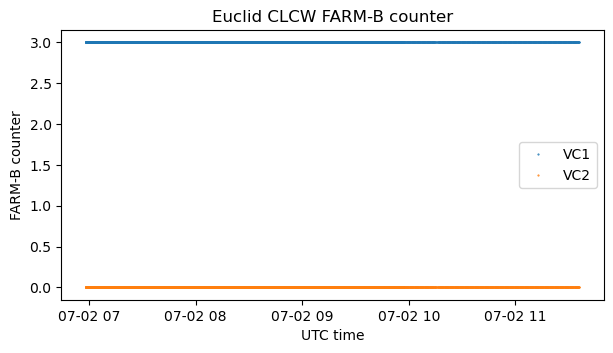

In [116]:
farm_b_counter_vc1 = np.array([c.farm_b_counter for c in clcw if c.virtual_channel_identification == 1])
farm_b_counter_vc2 = np.array([c.farm_b_counter for c in clcw if c.virtual_channel_identification == 2])
plt.plot(t_frame[cvc == 1], farm_b_counter_vc1, '.', label='VC1', markersize=1)
plt.plot(t_frame[cvc == 2], farm_b_counter_vc2, '.', label='VC2', markersize=1)
plt.legend()
plt.title('Euclid CLCW FARM-B counter')
plt.ylabel('FARM-B counter')
plt.xlabel('UTC time');

In [117]:
np.unique(farm_b_counter_vc1), np.unique(farm_b_counter_vc2)

(array([3]), array([0]))